In [244]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



In [245]:
USE_GPU = True
TRAIN = False

In [246]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1726679856.558735    4296 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726679856.560263    4296 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726679856.561780    4296 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726679856.563308    4296 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [247]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
CRITIC_LEARNING_RATE = 0.0002
GENERATOR_LEARNING_RATE = 0.0008
EPOCHS = 600
CRITIC_STEPS = 5
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100
STEPS_PER_EPOCH = 3
REPEAT_DATA = 30

In [248]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((852, 188), (852, 2), (188, 2), (852, 14, 14, 1), 196)

In [249]:
critic = Sequential(
    [
        Input(shape=X.shape[1:]),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_144 (Conv2D)             │ (None, 7, 7, 14)       │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_160 (LeakyReLU)     │ (None, 7, 7, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 4, 4, 28)       │         3,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_161 (LeakyReLU)     │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 2, 2, 56)       │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_162 (LeakyReLU)     │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 1, 1, 112)      │        56,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_163 (LeakyReLU)     │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 1, 1, 196)      │        88,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_164 (LeakyReLU)     │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 196)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,428 (634.48 KB)

 Trainable params: 162,428 (634.48 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
        ),
        layers.Reshape(X.shape[1:]),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_32 (Reshape)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_80             │ (None, 4, 4, 196)      │       614,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 4, 4, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 2, 2, 112)      │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_165 (LeakyReLU)     │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 1, 1, 56)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_166 (LeakyReLU)     │ (None, 1, 1, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_81             │ (None, 2, 2, 28)       │        25,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_167 (LeakyReLU)     │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_82             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 2, 2, 28)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 2, 2, 28)       │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_168 (LeakyReLU)     │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_83             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 1, 1, 56)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │             

 Total params: 1,810,676 (6.91 MB)

 Trainable params: 1,810,172 (6.91 MB)

 Non-trainable params: 504 (1.97 KB)

In [251]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [252]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [253]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - c_gp: 0.2815 - c_loss: 2.8187 - c_wass_loss: 0.0040 - g_loss: -0.0052 

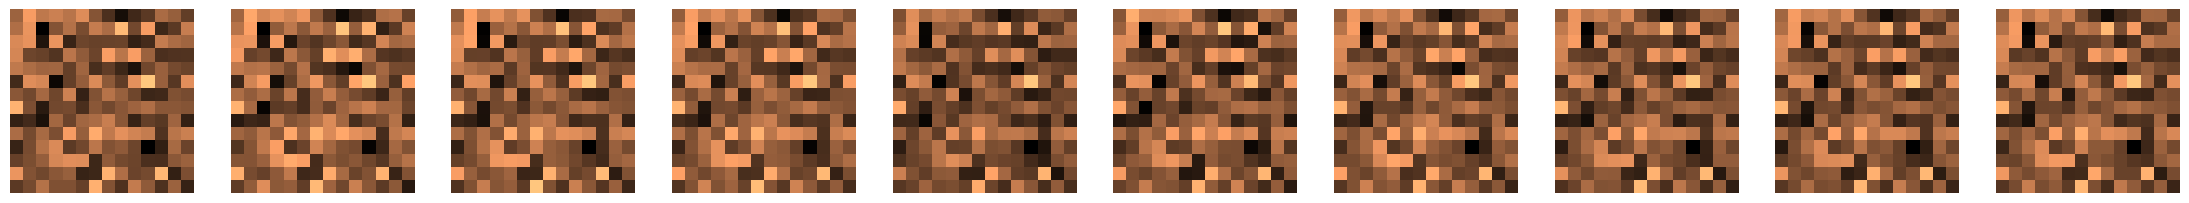

3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - c_gp: 0.2639 - c_loss: 2.6433 - c_wass_loss: 0.0041 - g_loss: -0.0054
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0487 - c_loss: 0.4910 - c_wass_loss: 0.0038 - g_loss: -0.0062
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0332 - c_loss: 0.3332 - c_wass_loss: 0.0011 - g_loss: -0.0053
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0295 - c_loss: 0.2952 - c_wass_loss: -1.4949e-04 - g_loss: -0.0056
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0278 - c_loss: 0.2769 - c_wass_loss: -6.0353e-04 - g_loss: -0.0061
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0230 - c_loss: 0.2288 - c_wass_loss: -9.5640e-04 - g_loss: -0.0067
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0228 - c_loss: 0.2270 - c_wass_loss: -0.0012 - g_loss: -0.0072
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0229 - c_loss: 0.2272 - c_wass_loss: -0.0014 - g_loss: -0.0075
Epoch 9/600
3/3 ━━

/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


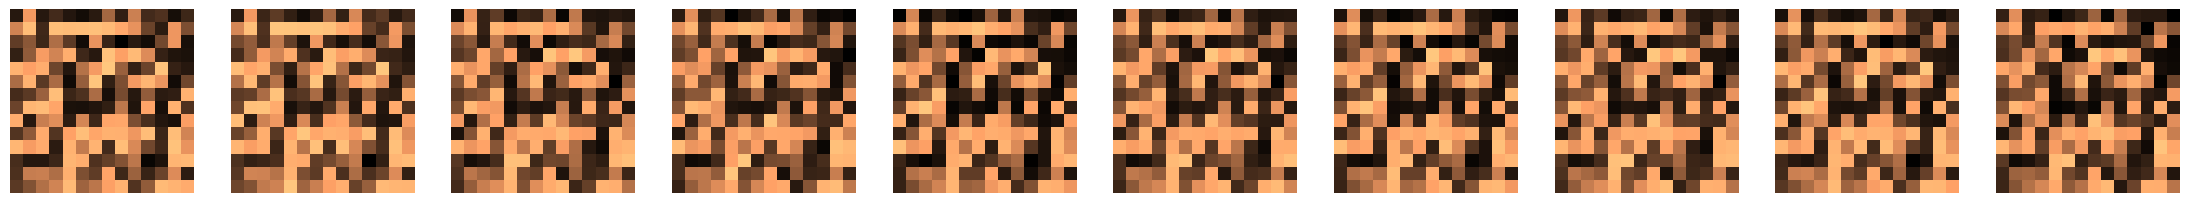

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 12/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0185 - c_loss: 0.1824 - c_wass_loss: -0.0024 - g_loss: -0.0082
Epoch 13/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0190 - c_loss: 0.1869 - c_wass_loss: -0.0027 - g_loss: -0.0084
Epoch 14/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0182 - c_loss: 0.1786 - c_wass_loss: -0.0030 - g_loss: -0.0089
Epoch 15/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0188 - c_loss: 0.1851 - c_wass_loss: -0.0034 - g_loss: -0.0093
Epoch 16/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0188 - c_loss: 0.1849 - c_wass_loss: -0.0036 - g_loss: -0.0099
Epoch 17/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0179 - c_loss: 0.1752 - c_wass_loss: -0.0038 - g_loss: -0.0105
Epoch 18/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0168 - c_loss: 0.1638 - c_wass_loss: -0.0041 - g_loss: -0.0112
Epoch 1

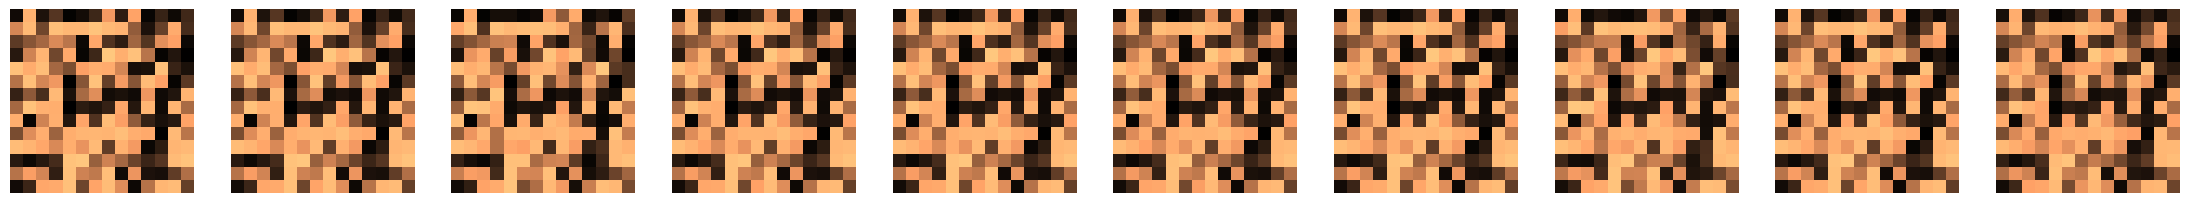

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0158 - c_loss: 0.1543 - c_wass_loss: -0.0040 - g_loss: -0.0142
Epoch 22/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0156 - c_loss: 0.1519 - c_wass_loss: -0.0040 - g_loss: -0.0153
Epoch 24/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0151 - c_loss: 0.1467 - c_wass_loss: -0.0044 - g_loss: -0.0160
Epoch 25/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0147 - c_loss: 0.1429 - c_wass_loss: -0.0042 - g_loss: -0.0169
Epoch 26/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0133 - c_loss: 0.1286 - c_wass_loss: -0.0043 - g_loss: -0.0179
Epoch 27/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0136 - c_loss: 0.1318 - c_wass_loss: -0.0044 - g_loss: -0.0186
Epoch 28/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0143 - c_loss: 0.1381 - c_wass_loss: -0.0048 - g_loss: -0.0193
Epoch 29

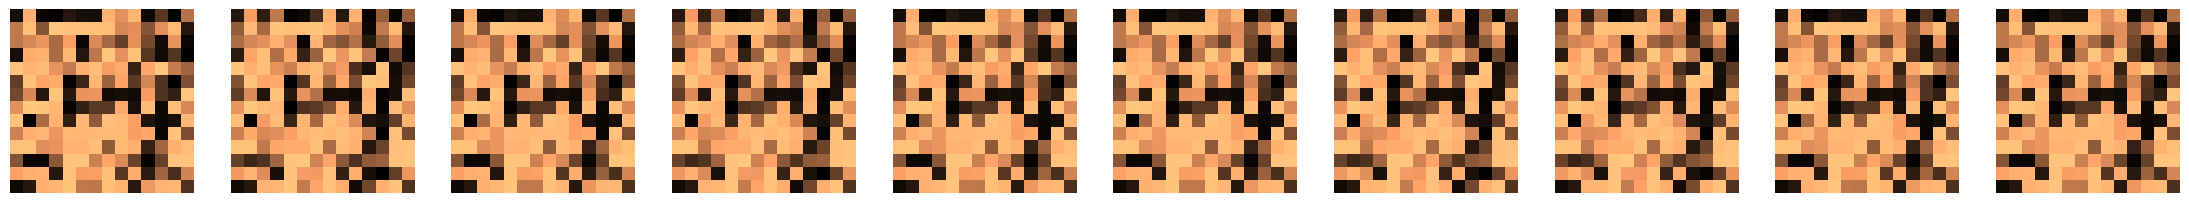

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - c_gp: 0.0137 - c_loss: 0.1318 - c_wass_loss: -0.0049 - g_loss: -0.0214
Epoch 32/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0122 - c_loss: 0.1168 - c_wass_loss: -0.0049 - g_loss: -0.0220
Epoch 33/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 34/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0129 - c_loss: 0.1240 - c_wass_loss: -0.0052 - g_loss: -0.0224
Epoch 35/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0121 - c_loss: 0.1153 - c_wass_loss: -0.0053 - g_loss: -0.0236
Epoch 36/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0126 - c_loss: 0.1206 - c_wass_loss: -0.0055 - g_loss: -0.0242
Epoch 37/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0121 - c_loss: 0.1159 - c_wass_loss: -0.0054 - g_loss: -0.0249
Epoch 38/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0124 - c_loss: 0.1179 - c_wass_loss: -0.0062 - g_loss: -0.0254
Epoch 39

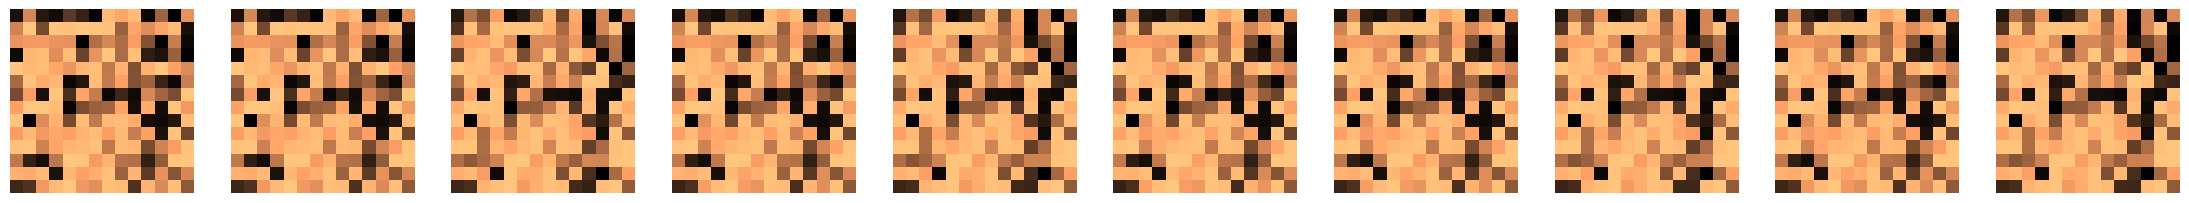

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0120 - c_loss: 0.1134 - c_wass_loss: -0.0065 - g_loss: -0.0282
Epoch 42/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0115 - c_loss: 0.1083 - c_wass_loss: -0.0067 - g_loss: -0.0291
Epoch 43/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0115 - c_loss: 0.1077 - c_wass_loss: -0.0072 - g_loss: -0.0299
Epoch 44/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0113 - c_loss: 0.1060 - c_wass_loss: -0.0073 - g_loss: -0.0306
Epoch 46/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0110 - c_loss: 0.1032 - c_wass_loss: -0.0072 - g_loss: -0.0315
Epoch 47/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0114 - c_loss: 0.1067 - c_wass_loss: -0.0072 - g_loss: -0.0323
Epoch 48/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0102 - c_loss: 0.0945 - c_wass_loss: -0.0076 - g_loss: -0.0334
Epoch 49

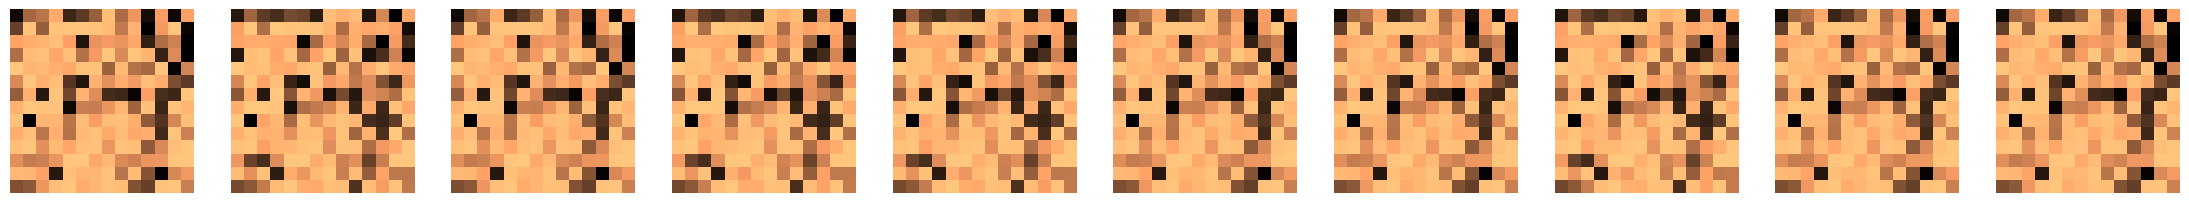

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - c_gp: 0.0107 - c_loss: 0.0991 - c_wass_loss: -0.0079 - g_loss: -0.0362
Epoch 52/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0094 - c_loss: 0.0867 - c_wass_loss: -0.0076 - g_loss: -0.0369
Epoch 53/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0092 - c_loss: 0.0850 - c_wass_loss: -0.0075 - g_loss: -0.0377
Epoch 54/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0099 - c_loss: 0.0917 - c_wass_loss: -0.0078 - g_loss: -0.0384
Epoch 55/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 56/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0099 - c_loss: 0.0909 - c_wass_loss: -0.0076 - g_loss: -0.0393
Epoch 57/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0096 - c_loss: 0.0887 - c_wass_loss: -0.0072 - g_loss: -0.0402
Epoch 58/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0095 - c_loss: 0.0879 - c_wass_loss: -0.0068 - g_loss: -0.0408
Epoch 59

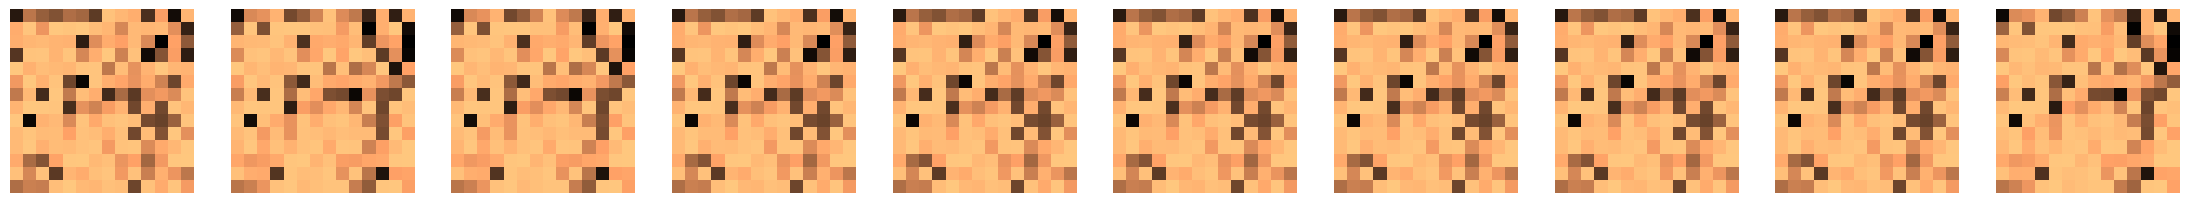

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - c_gp: 0.0090 - c_loss: 0.0829 - c_wass_loss: -0.0070 - g_loss: -0.0428
Epoch 62/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0092 - c_loss: 0.0853 - c_wass_loss: -0.0069 - g_loss: -0.0438
Epoch 63/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0093 - c_loss: 0.0859 - c_wass_loss: -0.0070 - g_loss: -0.0445
Epoch 64/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0087 - c_loss: 0.0806 - c_wass_loss: -0.0064 - g_loss: -0.0454
Epoch 65/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0087 - c_loss: 0.0806 - c_wass_loss: -0.0062 - g_loss: -0.0463
Epoch 66/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 67/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0081 - c_loss: 0.0751 - c_wass_loss: -0.0059 - g_loss: -0.0466
Epoch 68/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0086 - c_loss: 0.0801 - c_wass_loss: -0.0059 - g_loss: -0.0475
Epoch 69

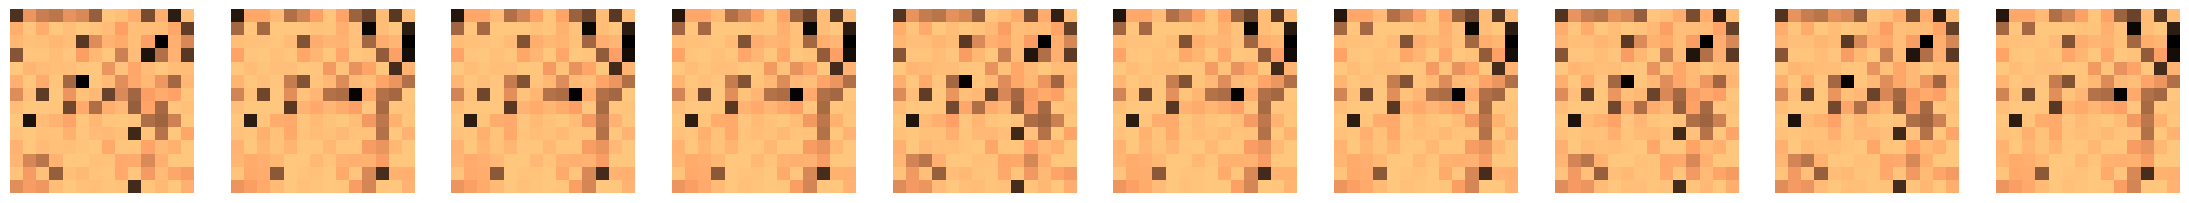

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - c_gp: 0.0085 - c_loss: 0.0795 - c_wass_loss: -0.0052 - g_loss: -0.0487
Epoch 72/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0084 - c_loss: 0.0791 - c_wass_loss: -0.0051 - g_loss: -0.0496
Epoch 73/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0082 - c_loss: 0.0773 - c_wass_loss: -0.0051 - g_loss: -0.0497
Epoch 74/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0080 - c_loss: 0.0748 - c_wass_loss: -0.0053 - g_loss: -0.0503
Epoch 75/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0079 - c_loss: 0.0738 - c_wass_loss: -0.0048 - g_loss: -0.0508
Epoch 76/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0079 - c_loss: 0.0742 - c_wass_loss: -0.0045 - g_loss: -0.0509
Epoch 77/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 78/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0083 - c_loss: 0.0792 - c_wass_loss: -0.0043 - g_loss: -0.0509
Epoch 79

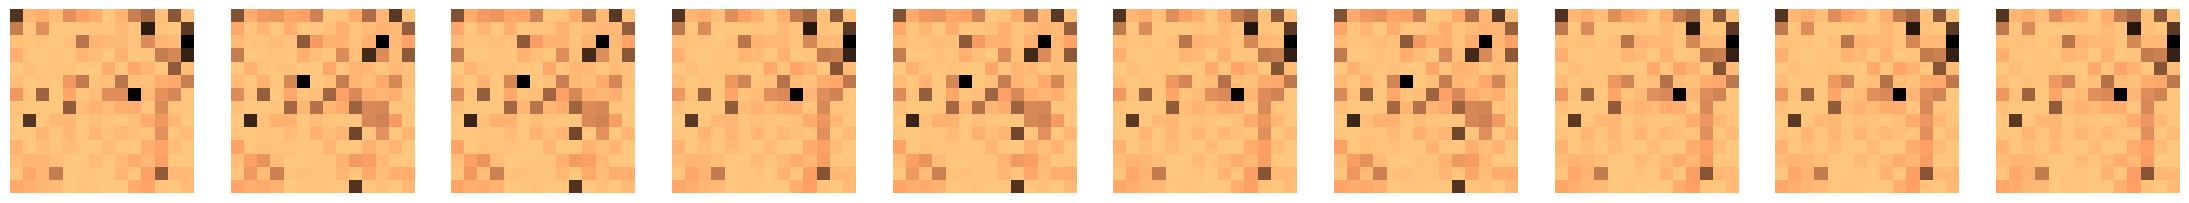

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - c_gp: 0.0079 - c_loss: 0.0748 - c_wass_loss: -0.0037 - g_loss: -0.0515
Epoch 82/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0075 - c_loss: 0.0718 - c_wass_loss: -0.0034 - g_loss: -0.0517
Epoch 83/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0074 - c_loss: 0.0706 - c_wass_loss: -0.0035 - g_loss: -0.0523
Epoch 84/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0077 - c_loss: 0.0734 - c_wass_loss: -0.0033 - g_loss: -0.0524
Epoch 85/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0072 - c_loss: 0.0686 - c_wass_loss: -0.0031 - g_loss: -0.0525
Epoch 86/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0070 - c_loss: 0.0674 - c_wass_loss: -0.0029 - g_loss: -0.0525
Epoch 87/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0072 - c_loss: 0.0698 - c_wass_loss: -0.0027 - g_loss: -0.0527
Epoch 88/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 89

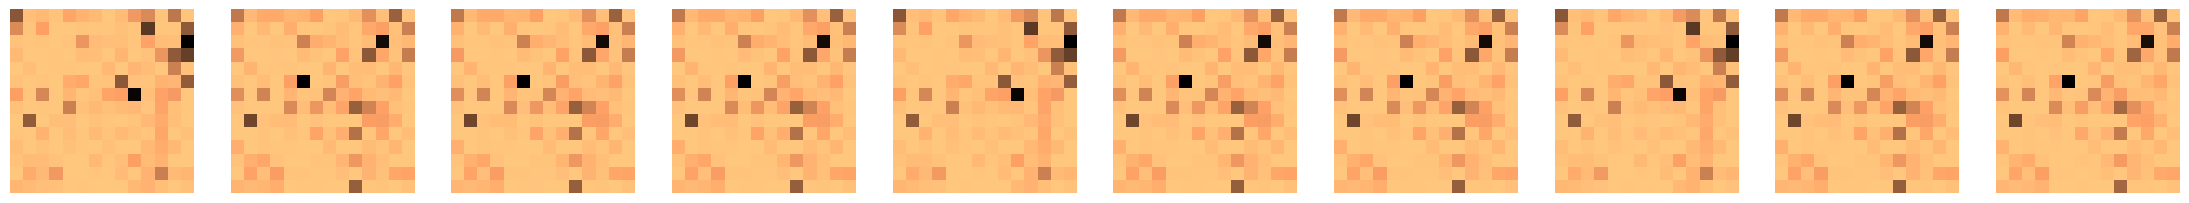

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - c_gp: 0.0068 - c_loss: 0.0655 - c_wass_loss: -0.0027 - g_loss: -0.0537
Epoch 92/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0073 - c_loss: 0.0701 - c_wass_loss: -0.0025 - g_loss: -0.0539
Epoch 93/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0070 - c_loss: 0.0680 - c_wass_loss: -0.0022 - g_loss: -0.0544
Epoch 94/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0070 - c_loss: 0.0679 - c_wass_loss: -0.0023 - g_loss: -0.0542
Epoch 95/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0065 - c_loss: 0.0634 - c_wass_loss: -0.0014 - g_loss: -0.0542
Epoch 96/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0070 - c_loss: 0.0688 - c_wass_loss: -0.0015 - g_loss: -0.0543
Epoch 97/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0072 - c_loss: 0.0702 - c_wass_loss: -0.0018 - g_loss: -0.0541
Epoch 98/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0067 - c_loss: 0.0651 - c_wass_loss: -0.0017 - g_loss: -0.0540
Epoch 99/600
3/3 ━━━

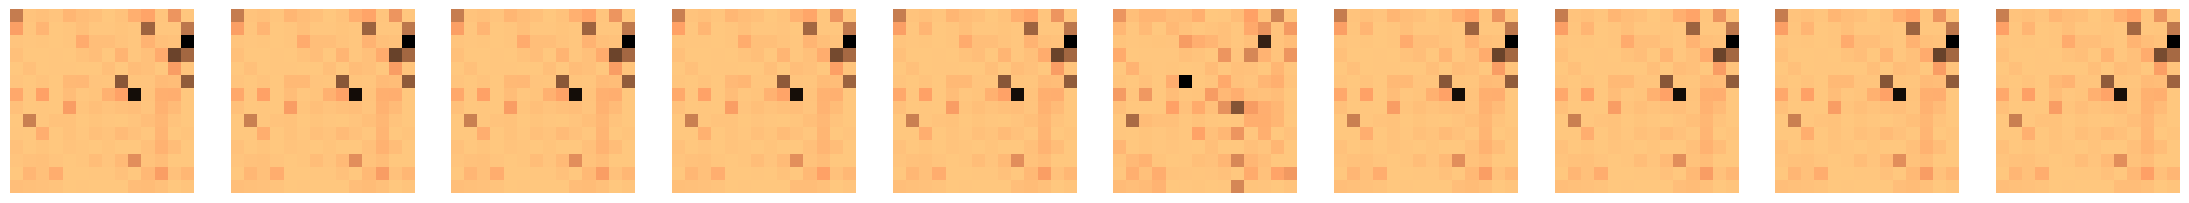

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0070 - c_loss: 0.0688 - c_wass_loss: -0.0016 - g_loss: -0.0548
Epoch 102/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0070 - c_loss: 0.0681 - c_wass_loss: -0.0015 - g_loss: -0.0551
Epoch 103/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0068 - c_loss: 0.0664 - c_wass_loss: -0.0013 - g_loss: -0.0556
Epoch 104/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0067 - c_loss: 0.0653 - c_wass_loss: -0.0013 - g_loss: -0.0559
Epoch 105/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0071 - c_loss: 0.0697 - c_wass_loss: -0.0014 - g_loss: -0.0559
Epoch 106/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0071 - c_loss: 0.0702 - c_wass_loss: -7.8773e-04 - g_loss: -0.0566
Epoch 107/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0073 - c_loss: 0.0720 - c_wass_loss: -7.2957e-04 - g_loss: -0.0563
Epoch 108/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0064 - c_loss: 0.0632 - c_wass_loss: -0.0011 - g_loss: -0.0566
Epoch 

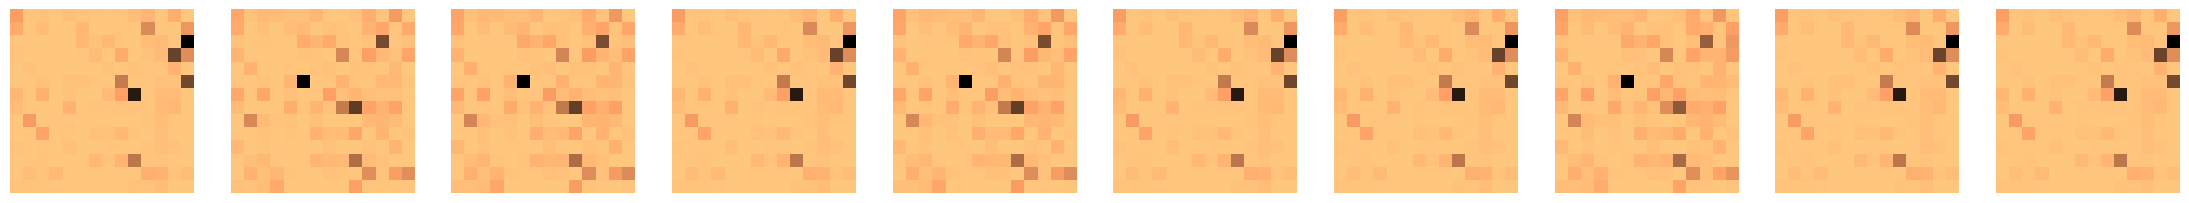

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - c_gp: 0.0068 - c_loss: 0.0675 - c_wass_loss: -8.3428e-04 - g_loss: -0.0569
Epoch 112/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0066 - c_loss: 0.0652 - c_wass_loss: -5.7271e-04 - g_loss: -0.0567
Epoch 113/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0071 - c_loss: 0.0699 - c_wass_loss: -7.6570e-04 - g_loss: -0.0567
Epoch 114/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0065 - c_loss: 0.0642 - c_wass_loss: -8.6240e-04 - g_loss: -0.0566
Epoch 115/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0068 - c_loss: 0.0677 - c_wass_loss: -6.9151e-04 - g_loss: -0.0565
Epoch 116/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0062 - c_loss: 0.0609 - c_wass_loss: -8.7427e-04 - g_loss: -0.0562
Epoch 117/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0067 - c_loss: 0.0664 - c_wass_loss: -8.6207e-04 - g_loss: -0.0565
Epoch 118/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0068 - c_loss: 0.0674 - c_wass_loss: -8.6691e-04 

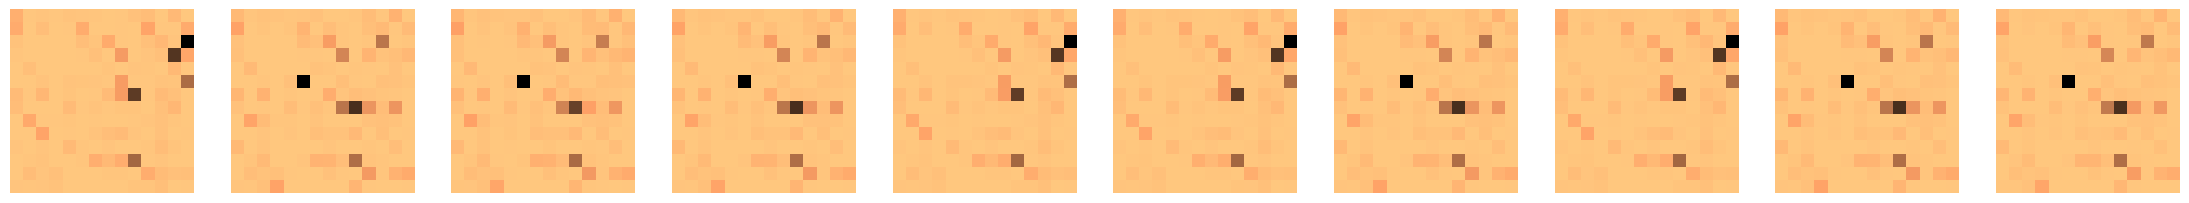

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 122/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0062 - c_loss: 0.0611 - c_wass_loss: -5.6090e-04 - g_loss: -0.0561
Epoch 123/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0064 - c_loss: 0.0629 - c_wass_loss: -7.3058e-04 - g_loss: -0.0566
Epoch 124/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0066 - c_loss: 0.0652 - c_wass_loss: -6.2247e-04 - g_loss: -0.0563
Epoch 125/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0064 - c_loss: 0.0636 - c_wass_loss: -5.2643e-04 - g_loss: -0.0567
Epoch 126/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0065 - c_loss: 0.0645 - c_wass_loss: -5.2964e-04 - g_loss: -0.0568
Epoch 127/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0067 - c_loss: 0.0666 - c_wass_loss: -5.1145e-04 - g_loss: -0.0572
Epoch 128/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0063 - c_loss: 0.0627 - c_wass_loss: -4

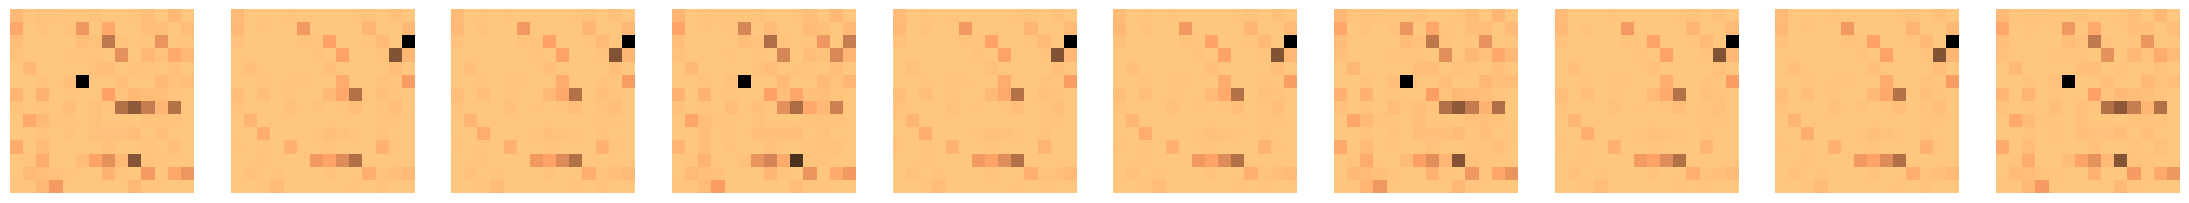

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0067 - c_loss: 0.0669 - c_wass_loss: -3.3981e-04 - g_loss: -0.0570
Epoch 132/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 133/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0061 - c_loss: 0.0611 - c_wass_loss: -3.9817e-04 - g_loss: -0.0564
Epoch 134/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0062 - c_loss: 0.0610 - c_wass_loss: -8.0591e-04 - g_loss: -0.0561
Epoch 135/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0067 - c_loss: 0.0672 - c_wass_loss: -1.0484e-04 - g_loss: -0.0566
Epoch 136/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0064 - c_loss: 0.0633 - c_wass_loss: -5.0614e-04 - g_loss: -0.0565
Epoch 137/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0065 - c_loss: 0.0641 - c_wass_loss: -3.9426e-04 - g_loss: -0.0566
Epoch 138/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0065 - c_loss: 0.0651 - c_wass_loss: -2.

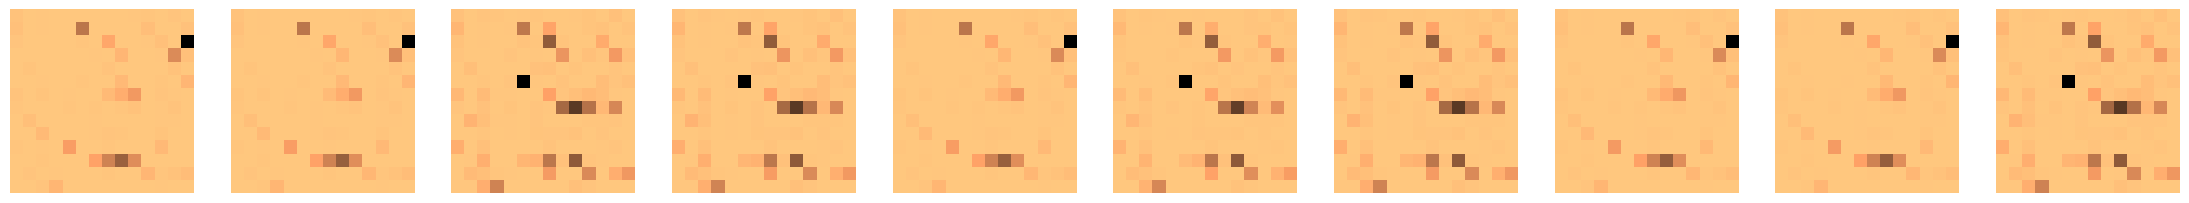

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - c_gp: 0.0060 - c_loss: 0.0588 - c_wass_loss: -7.7359e-04 - g_loss: -0.0561
Epoch 142/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0061 - c_loss: 0.0599 - c_wass_loss: -6.8099e-04 - g_loss: -0.0563
Epoch 143/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 144/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0061 - c_loss: 0.0606 - c_wass_loss: -7.7672e-04 - g_loss: -0.0562
Epoch 145/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0063 - c_loss: 0.0626 - c_wass_loss: -4.5984e-04 - g_loss: -0.0569
Epoch 146/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0064 - c_loss: 0.0637 - c_wass_loss: -5.6869e-05 - g_loss: -0.0571
Epoch 147/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0062 - c_loss: 0.0613 - c_wass_loss: -4.5560e-04 - g_loss: -0.0571
Epoch 148/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0060 - c_loss: 0.0600 - c_wass_loss: -2.

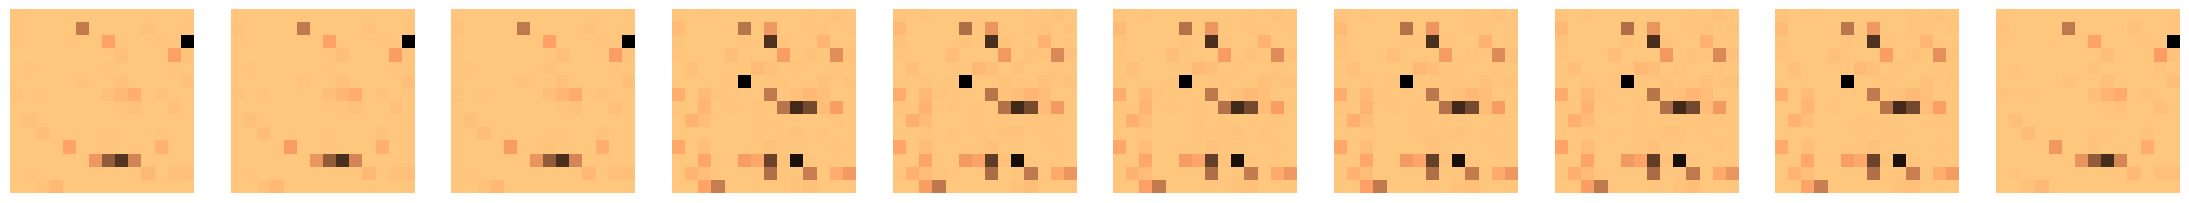

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - c_gp: 0.0060 - c_loss: 0.0599 - c_wass_loss: -2.1524e-04 - g_loss: -0.0560
Epoch 152/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0553 - c_wass_loss: -2.8464e-04 - g_loss: -0.0555
Epoch 153/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0060 - c_loss: 0.0596 - c_wass_loss: 2.2101e-05 - g_loss: -0.0550
Epoch 154/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 155/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0061 - c_loss: 0.0607 - c_wass_loss: -1.7341e-04 - g_loss: -0.0552
Epoch 156/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0569 - c_wass_loss: -4.7456e-04 - g_loss: -0.0555
Epoch 157/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0585 - c_wass_loss: 1.4037e-04 - g_loss: -0.0546
Epoch 158/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0060 - c_loss: 0.0590 - c_wass_loss: -7.92

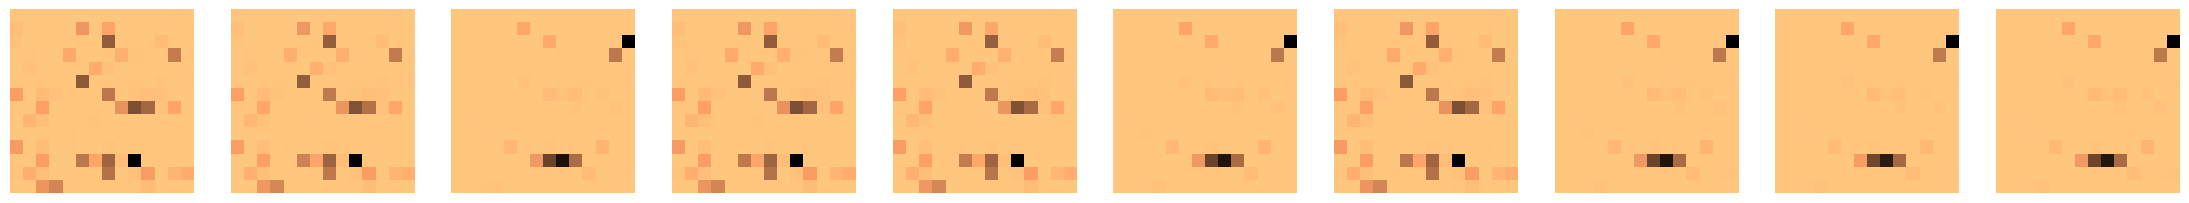

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - c_gp: 0.0057 - c_loss: 0.0566 - c_wass_loss: -3.1925e-04 - g_loss: -0.0546
Epoch 162/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0061 - c_loss: 0.0612 - c_wass_loss: -1.6527e-04 - g_loss: -0.0548
Epoch 163/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0577 - c_wass_loss: -9.2734e-04 - g_loss: -0.0547
Epoch 164/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0058 - c_loss: 0.0581 - c_wass_loss: -3.7489e-04 - g_loss: -0.0549
Epoch 165/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 166/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0580 - c_wass_loss: -3.2113e-04 - g_loss: -0.0554
Epoch 167/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0580 - c_wass_loss: -2.8202e-04 - g_loss: -0.0551
Epoch 168/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0588 - c_wass_loss: -8.

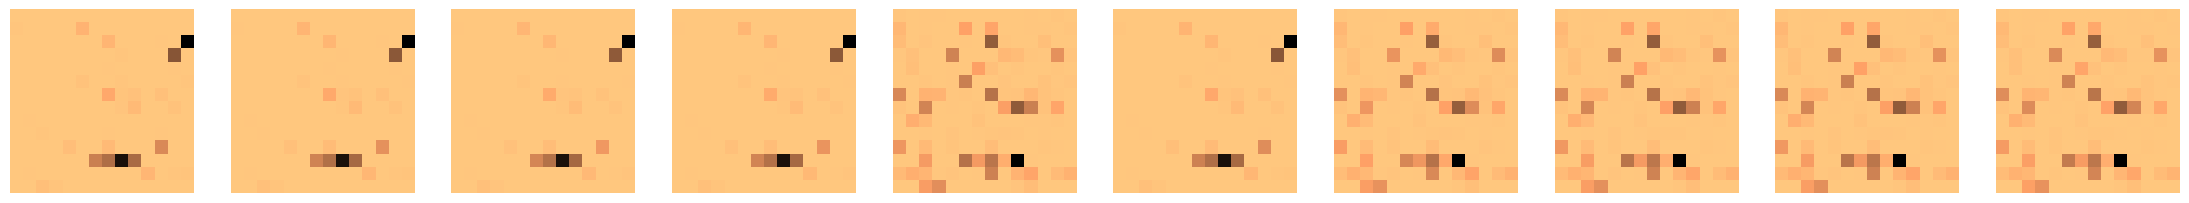

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - c_gp: 0.0056 - c_loss: 0.0560 - c_wass_loss: -8.0472e-05 - g_loss: -0.0551
Epoch 172/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0555 - c_wass_loss: -1.3327e-04 - g_loss: -0.0554
Epoch 173/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0058 - c_loss: 0.0572 - c_wass_loss: -4.1528e-04 - g_loss: -0.0556
Epoch 174/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0058 - c_loss: 0.0573 - c_wass_loss: -5.3149e-04 - g_loss: -0.0560
Epoch 175/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0544 - c_wass_loss: -2.5683e-04 - g_loss: -0.0557
Epoch 176/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 177/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0058 - c_loss: 0.0582 - c_wass_loss: -1.9158e-04 - g_loss: -0.0559
Epoch 178/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0059 - c_loss: 0.0592 - c_wass_loss: -2

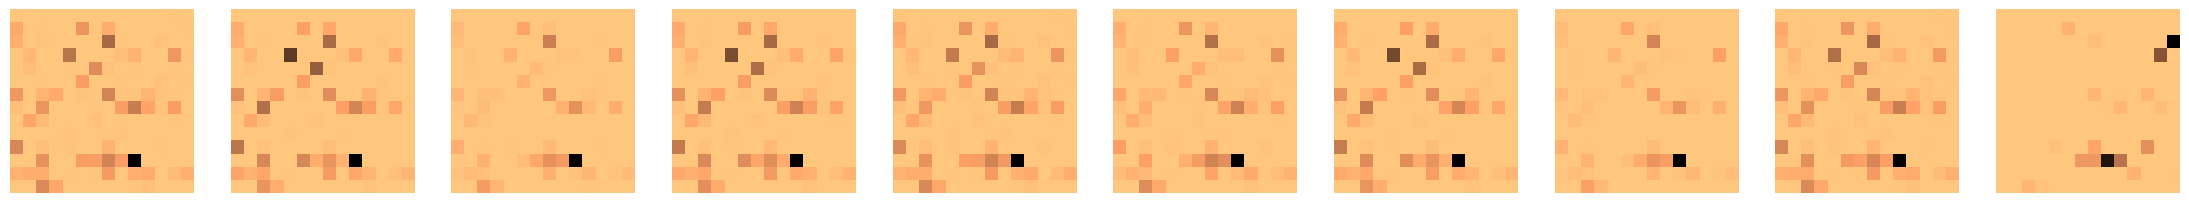

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - c_gp: 0.0058 - c_loss: 0.0577 - c_wass_loss: 8.0190e-05 - g_loss: -0.0553
Epoch 182/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0058 - c_loss: 0.0572 - c_wass_loss: -3.9603e-04 - g_loss: -0.0555
Epoch 183/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: 3.3515e-05 - g_loss: -0.0551
Epoch 184/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0553 - c_wass_loss: -2.4870e-04 - g_loss: -0.0549
Epoch 185/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0573 - c_wass_loss: -7.3891e-05 - g_loss: -0.0548
Epoch 186/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0590 - c_wass_loss: -3.8874e-04 - g_loss: -0.0544
Epoch 187/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 188/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0558 - c_wass_loss: -4.45

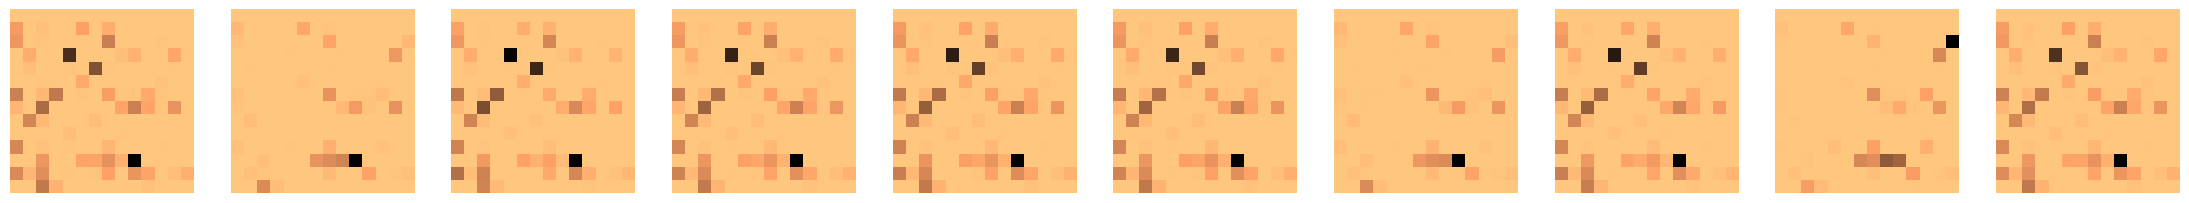

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0055 - c_loss: 0.0545 - c_wass_loss: -1.6171e-04 - g_loss: -0.0551
Epoch 192/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0580 - c_wass_loss: -1.6029e-04 - g_loss: -0.0546
Epoch 193/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0556 - c_wass_loss: 1.4070e-04 - g_loss: -0.0550
Epoch 194/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0587 - c_wass_loss: 2.2807e-04 - g_loss: -0.0549
Epoch 195/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0557 - c_wass_loss: 7.4556e-05 - g_loss: -0.0549
Epoch 196/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0058 - c_loss: 0.0582 - c_wass_loss: -1.6331e-04 - g_loss: -0.0547
Epoch 197/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0053 - c_loss: 0.0532 - c_wass_loss: -2.7365e-04 - g_loss: -0.0547
Epoch 198/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+

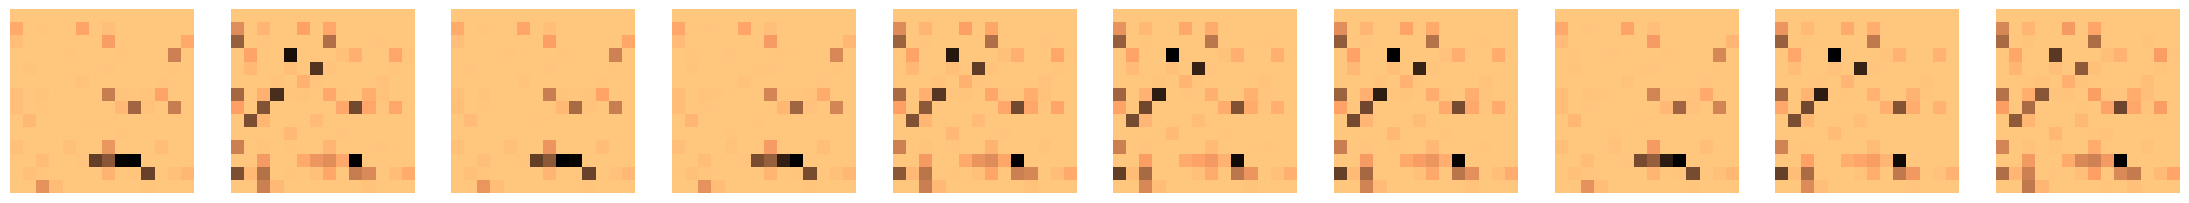

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0056 - c_loss: 0.0561 - c_wass_loss: 1.1646e-04 - g_loss: -0.0538
Epoch 202/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: 2.9138e-05 - g_loss: -0.0535
Epoch 203/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0594 - c_wass_loss: 2.2791e-04 - g_loss: -0.0534
Epoch 204/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0563 - c_wass_loss: 7.2389e-05 - g_loss: -0.0537
Epoch 205/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0538 - c_wass_loss: -2.3848e-05 - g_loss: -0.0528
Epoch 206/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0550 - c_wass_loss: -1.3652e-04 - g_loss: -0.0533
Epoch 207/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: -8.5399e-05 - g_loss: -0.0533
Epoch 208/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0582 - c_wass_loss: -1.0838e-04 - g_

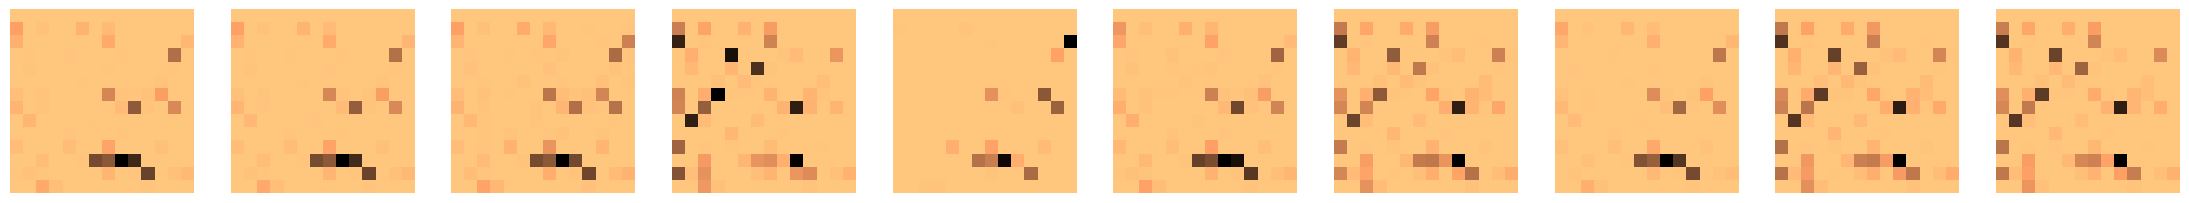

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0057 - c_loss: 0.0575 - c_wass_loss: 5.0342e-04 - g_loss: -0.0530
Epoch 212/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0056 - c_loss: 0.0565 - c_wass_loss: 1.6960e-04 - g_loss: -0.0522
Epoch 213/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0549 - c_wass_loss: 1.2636e-04 - g_loss: -0.0525
Epoch 214/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0556 - c_wass_loss: -2.1854e-04 - g_loss: -0.0526
Epoch 215/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0561 - c_wass_loss: -1.1705e-04 - g_loss: -0.0523
Epoch 216/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: 7.2907e-06 - g_loss: -0.0521 
Epoch 217/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0558 - c_wass_loss: 2.3773e-04 - g_loss: -0.0514
Epoch 218/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: -4.5332e-05 - g_

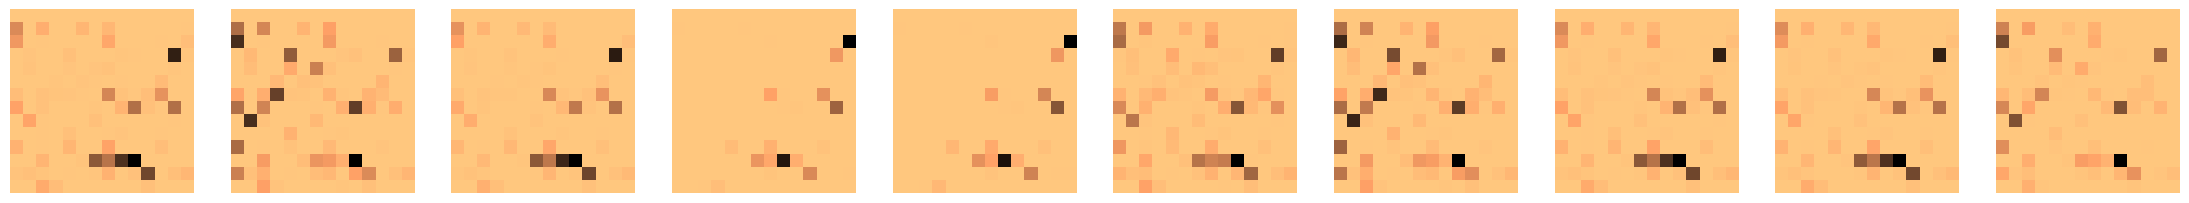

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.0054 - c_loss: 0.0544 - c_wass_loss: -1.9639e-05 - g_loss: -0.0518
Epoch 222/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0541 - c_wass_loss: -6.1329e-05 - g_loss: -0.0517
Epoch 223/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0053 - c_loss: 0.0525 - c_wass_loss: -4.2579e-04 - g_loss: -0.0512
Epoch 224/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0540 - c_wass_loss: -5.8248e-04 - g_loss: -0.0515
Epoch 225/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0563 - c_wass_loss: -4.3652e-04 - g_loss: -0.0514
Epoch 226/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0058 - c_loss: 0.0580 - c_wass_loss: 1.0797e-04 - g_loss: -0.0515
Epoch 227/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0059 - c_loss: 0.0588 - c_wass_loss: 3.2378e-05 - g_loss: -0.0511
Epoch 228/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0559 - c_wass_loss: 2.8161e-04 - g

2024-09-18 18:18:54.732363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16040414506481350282


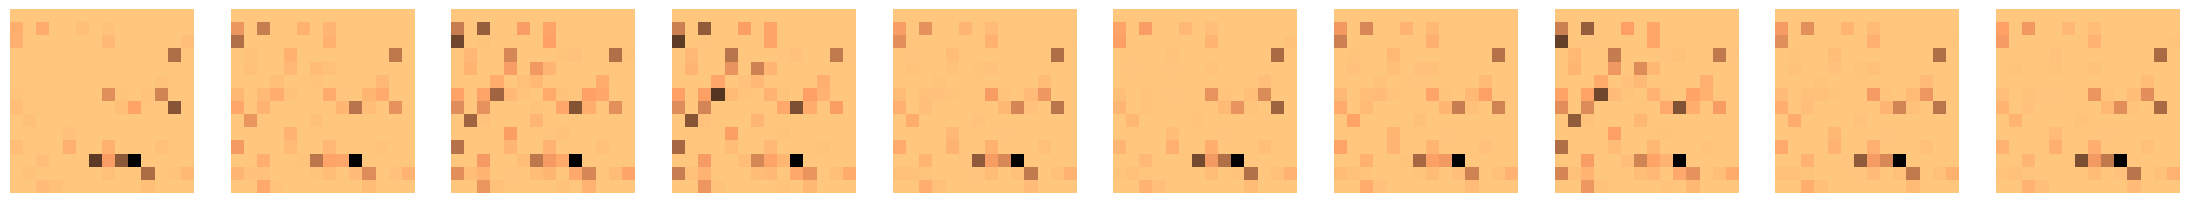

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 232/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0523 - c_wass_loss: -3.2604e-04 - g_loss: -0.0508
Epoch 233/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0053 - c_loss: 0.0532 - c_wass_loss: 1.6731e-05 - g_loss: -0.0500
Epoch 234/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0543 - c_wass_loss: 1.8564e-04 - g_loss: -0.0510
Epoch 235/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0057 - c_loss: 0.0578 - c_wass_loss: 3.1625e-04 - g_loss: -0.0509
Epoch 236/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0541 - c_wass_loss: 1.2962e-04 - g_loss: -0.0510
Epoch 237/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0057 - c_loss: 0.0567 - c_wass_loss: 1.5693e-04 - g_loss: -0.0500
Epoch 238/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0571 - c_wass_loss: -8.7548

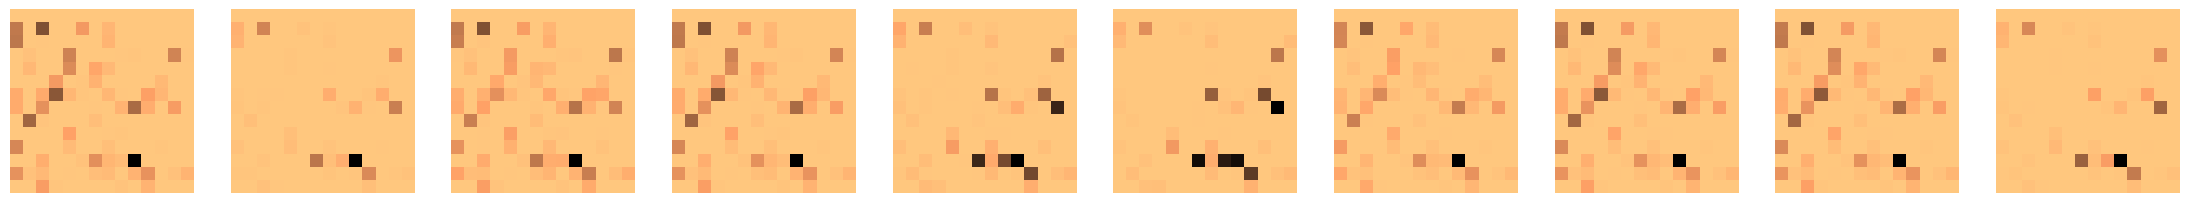

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0054 - c_loss: 0.0544 - c_wass_loss: 1.3911e-04 - g_loss: -0.0499
Epoch 242/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 243/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0053 - c_loss: 0.0535 - c_wass_loss: 4.2343e-04 - g_loss: -0.0495
Epoch 244/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0053 - c_loss: 0.0528 - c_wass_loss: -2.7851e-05 - g_loss: -0.0494
Epoch 245/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0543 - c_wass_loss: 8.7155e-06 - g_loss: -0.0489 
Epoch 246/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: 1.2916e-04 - g_loss: -0.0485
Epoch 247/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0551 - c_wass_loss: 3.3668e-04 - g_loss: -0.0481
Epoch 248/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0569 - c_wass_loss: 9.6072e

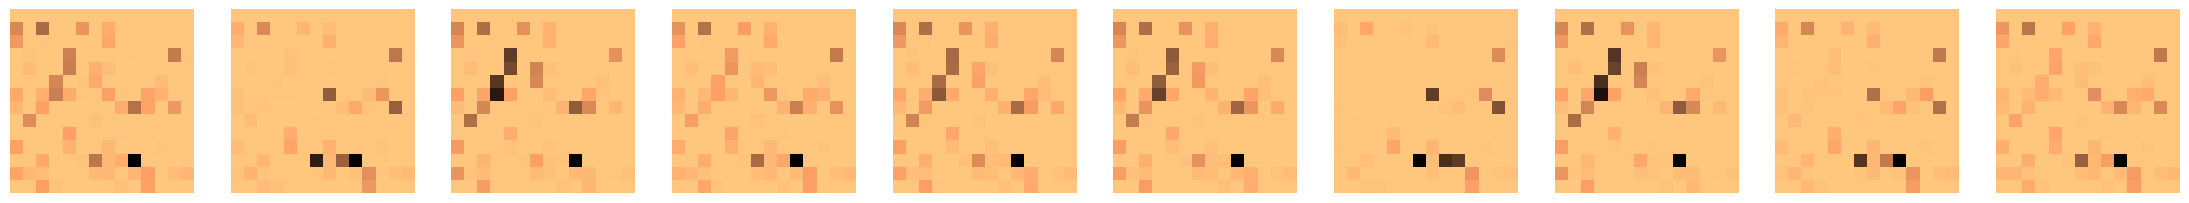

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0054 - c_loss: 0.0540 - c_wass_loss: -3.9851e-05 - g_loss: -0.0487
Epoch 252/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0553 - c_wass_loss: -5.0718e-04 - g_loss: -0.0487
Epoch 253/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 254/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0539 - c_wass_loss: 1.4999e-04 - g_loss: -0.0484
Epoch 255/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0588 - c_wass_loss: -2.2513e-04 - g_loss: -0.0483
Epoch 256/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: 1.4826e-04 - g_loss: -0.0475
Epoch 257/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0553 - c_wass_loss: 3.3400e-04 - g_loss: -0.0472
Epoch 258/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0546 - c_wass_loss: -3.727

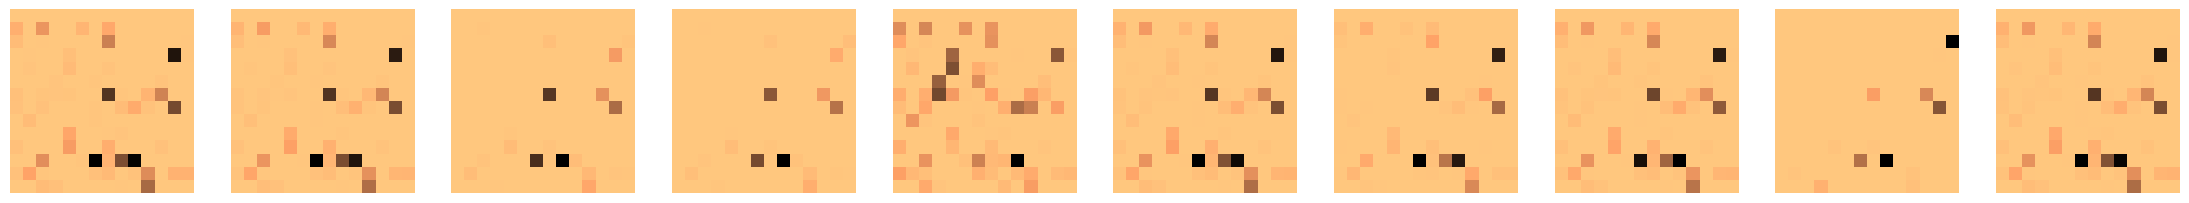

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0056 - c_loss: 0.0557 - c_wass_loss: 1.1112e-04 - g_loss: -0.0474
Epoch 262/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0057 - c_loss: 0.0577 - c_wass_loss: 4.9570e-04 - g_loss: -0.0473
Epoch 263/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0556 - c_wass_loss: 1.5546e-04 - g_loss: -0.0472
Epoch 264/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 265/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0553 - c_wass_loss: 4.9283e-05 - g_loss: -0.0466
Epoch 266/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0540 - c_wass_loss: -1.2194e-04 - g_loss: -0.0469
Epoch 267/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0549 - c_wass_loss: -1.1329e-04 - g_loss: -0.0468
Epoch 268/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0552 - c_wass_loss: -1.6961

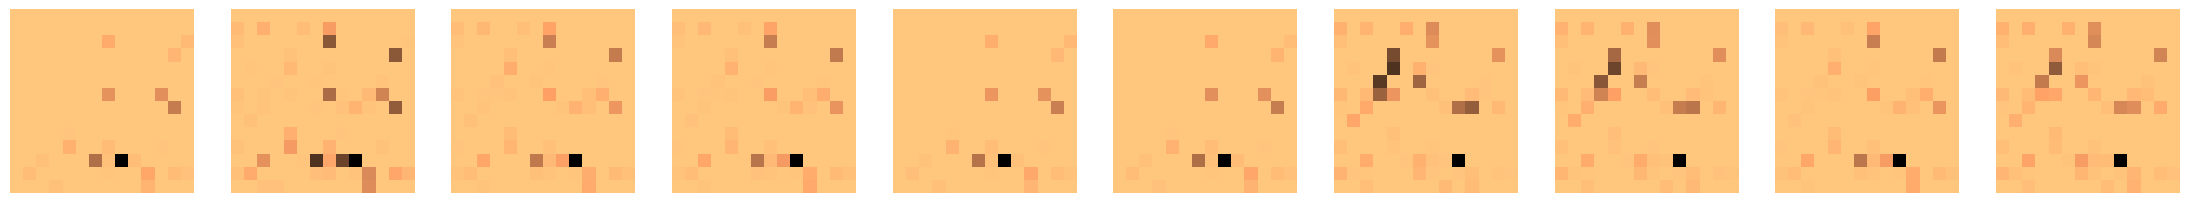

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - c_gp: 0.0053 - c_loss: 0.0529 - c_wass_loss: 1.9266e-05 - g_loss: -0.0462
Epoch 272/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0560 - c_wass_loss: -9.2522e-05 - g_loss: -0.0463
Epoch 273/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0058 - c_loss: 0.0579 - c_wass_loss: 1.0760e-04 - g_loss: -0.0458
Epoch 274/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0540 - c_wass_loss: -1.7140e-05 - g_loss: -0.0452
Epoch 275/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 276/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0059 - c_loss: 0.0585 - c_wass_loss: -5.8453e-05 - g_loss: -0.0451
Epoch 277/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0530 - c_wass_loss: -1.9080e-04 - g_loss: -0.0458
Epoch 278/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0545 - c_wass_loss: -8.81

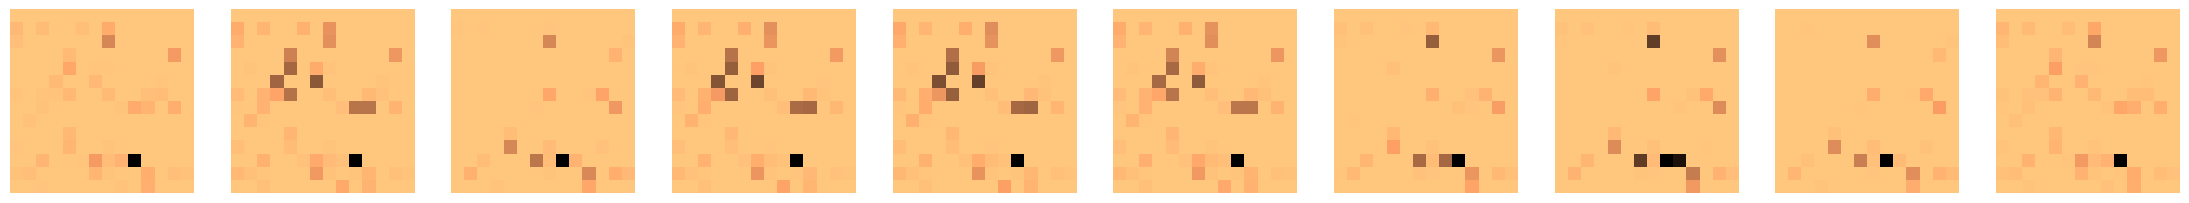

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0055 - c_loss: 0.0554 - c_wass_loss: -6.7677e-05 - g_loss: -0.0448
Epoch 282/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0543 - c_wass_loss: 3.8579e-04 - g_loss: -0.0447
Epoch 283/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0053 - c_loss: 0.0533 - c_wass_loss: 2.5524e-06 - g_loss: -0.0436
Epoch 284/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0054 - c_loss: 0.0546 - c_wass_loss: 1.2170e-04 - g_loss: -0.0438
Epoch 285/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0054 - c_loss: 0.0538 - c_wass_loss: 5.2712e-05 - g_loss: -0.0439
Epoch 286/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 287/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0538 - c_wass_loss: 1.9359e-05 - g_loss: -0.0436 
Epoch 288/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0050 - c_loss: 0.0504 - c_wass_loss: 9.0523e

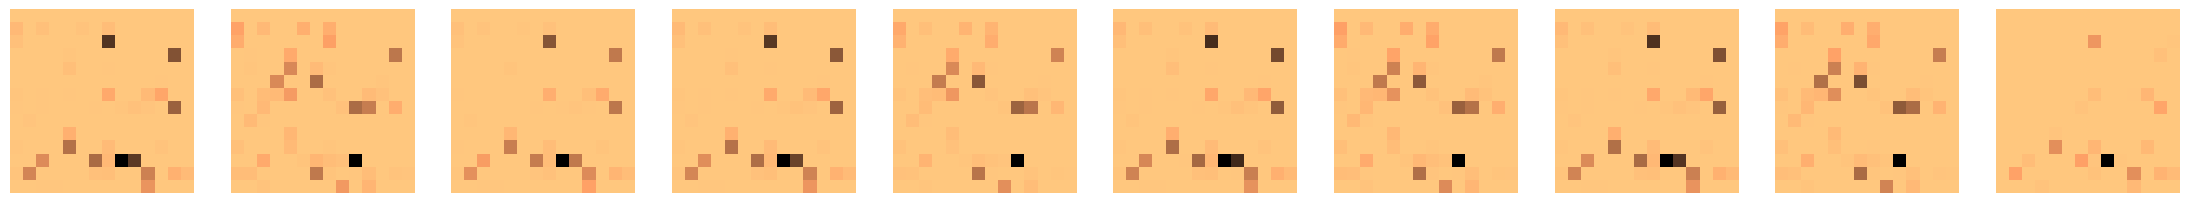

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0058 - c_loss: 0.0584 - c_wass_loss: -2.9089e-05 - g_loss: -0.0424
Epoch 292/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0537 - c_wass_loss: -1.2041e-04 - g_loss: -0.0425
Epoch 293/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0051 - c_loss: 0.0514 - c_wass_loss: -1.9978e-06 - g_loss: -0.0417
Epoch 294/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0559 - c_wass_loss: 8.2194e-06 - g_loss: -0.0417
Epoch 295/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0539 - c_wass_loss: -1.7748e-04 - g_loss: -0.0416
Epoch 296/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0565 - c_wass_loss: 2.8663e-04 - g_loss: -0.0415
Epoch 297/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 298/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0054 - c_loss: 0.0537 - c_wass_loss: -3.89

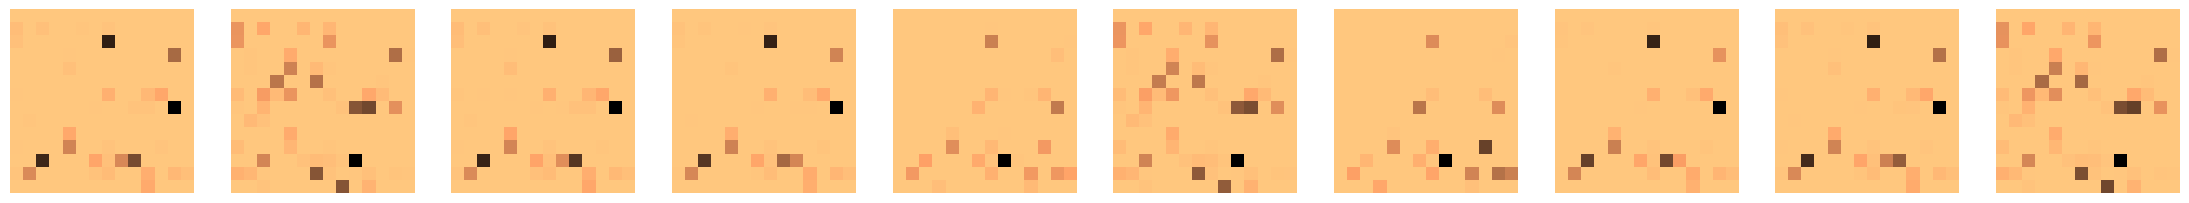

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 997ms/step - c_gp: 0.0053 - c_loss: 0.0526 - c_wass_loss: 3.2765e-05 - g_loss: -0.0402
Epoch 302/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0538 - c_wass_loss: 2.5108e-04 - g_loss: -0.0400
Epoch 303/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0564 - c_wass_loss: 3.1433e-04 - g_loss: -0.0402
Epoch 304/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0541 - c_wass_loss: 1.7845e-04 - g_loss: -0.0391
Epoch 305/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0534 - c_wass_loss: 6.7096e-05 - g_loss: -0.0389
Epoch 306/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0553 - c_wass_loss: -7.9918e-05 - g_loss: -0.0388
Epoch 307/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0560 - c_wass_loss: 4.9946e-04 - g_loss: -0.0381
Epoch 308/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00

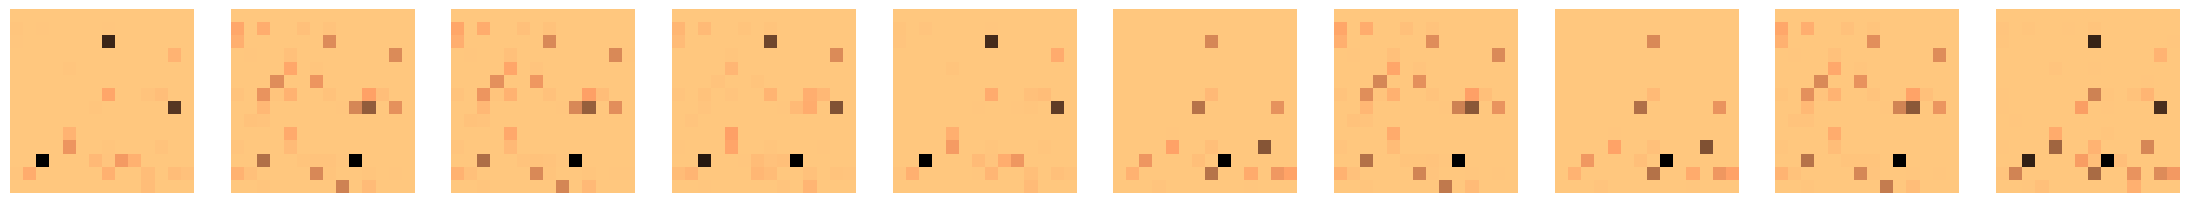

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0056 - c_loss: 0.0562 - c_wass_loss: -5.2836e-05 - g_loss: -0.0378
Epoch 312/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0056 - c_loss: 0.0564 - c_wass_loss: 3.2132e-04 - g_loss: -0.0377
Epoch 313/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0542 - c_wass_loss: -4.0928e-04 - g_loss: -0.0368
Epoch 314/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0546 - c_wass_loss: -8.2478e-05 - g_loss: -0.0367
Epoch 315/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0053 - c_loss: 0.0527 - c_wass_loss: -9.7910e-05 - g_loss: -0.0363
Epoch 316/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0539 - c_wass_loss: 3.8785e-05 - g_loss: -0.0364
Epoch 317/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0052 - c_loss: 0.0521 - c_wass_loss: 6.9226e-05 - g_loss: -0.0365
Epoch 318/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0553 - c_wass_loss: 1.0372e-04 - g_

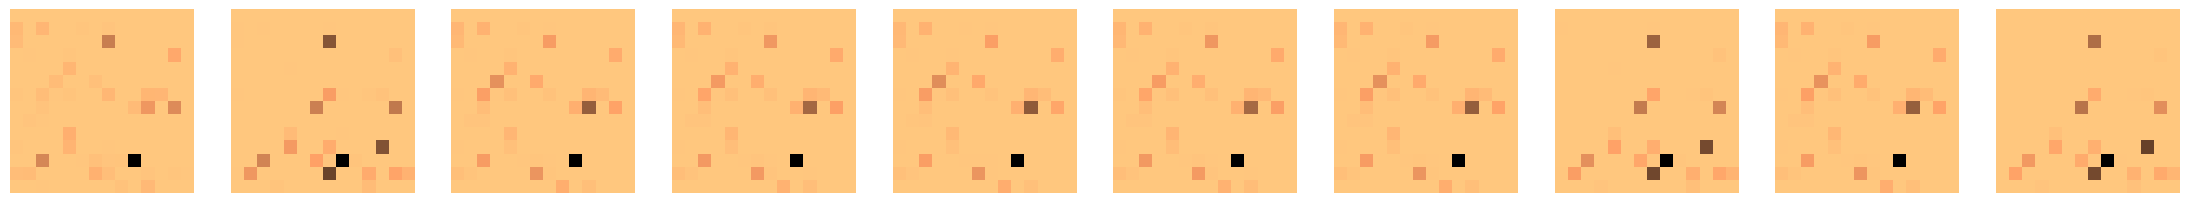

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0054 - c_loss: 0.0539 - c_wass_loss: -1.7619e-05 - g_loss: -0.0344
Epoch 322/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0057 - c_loss: 0.0567 - c_wass_loss: 1.4752e-04 - g_loss: -0.0342
Epoch 323/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0535 - c_wass_loss: -2.4080e-04 - g_loss: -0.0341
Epoch 324/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0052 - c_loss: 0.0525 - c_wass_loss: 2.1678e-04 - g_loss: -0.0332
Epoch 325/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0540 - c_wass_loss: 8.7132e-05 - g_loss: -0.0333
Epoch 326/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0052 - c_loss: 0.0526 - c_wass_loss: 1.8234e-04 - g_loss: -0.0328
Epoch 327/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - c_gp: 0.0053 - c_loss: 0.0530 - c_wass_loss: 1.4599e-04 - g_loss: -0.0324
Epoch 328/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0051 - c_loss: 0.0512 - c_wass_loss: 2.2272e-04 - g_lo

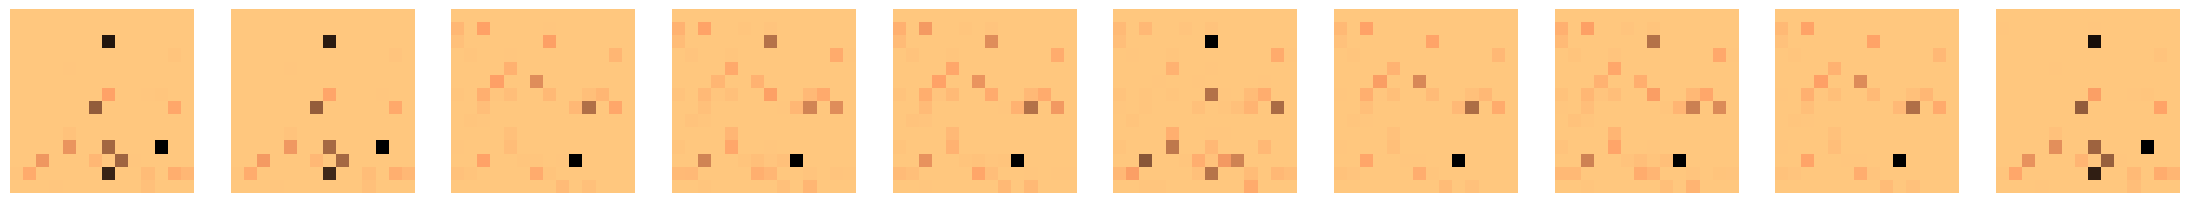

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0055 - c_loss: 0.0555 - c_wass_loss: 4.1000e-04 - g_loss: -0.0305
Epoch 332/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0536 - c_wass_loss: 3.2903e-04 - g_loss: -0.0297
Epoch 333/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0055 - c_loss: 0.0547 - c_wass_loss: 7.1359e-05 - g_loss: -0.0296
Epoch 334/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0553 - c_wass_loss: 9.2988e-05 - g_loss: -0.0287
Epoch 335/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0055 - c_loss: 0.0549 - c_wass_loss: -3.0849e-04 - g_loss: -0.0282
Epoch 336/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0057 - c_loss: 0.0570 - c_wass_loss: 3.5076e-05 - g_loss: -0.0275
Epoch 337/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0542 - c_wass_loss: 5.0575e-05 - g_loss: -0.0268
Epoch 338/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0052 - c_loss: 0.0528 - c_wass_loss: 2.7190e-04 - g_los

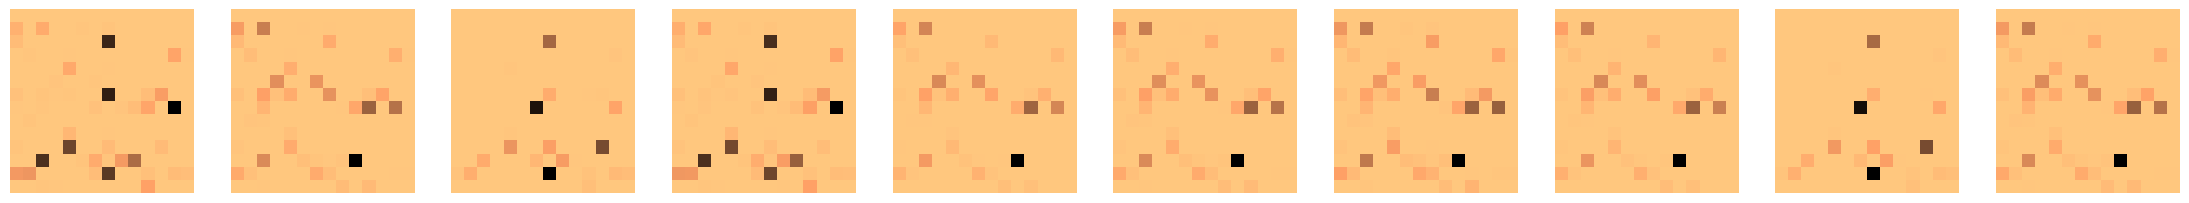

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 342/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0054 - c_loss: 0.0546 - c_wass_loss: 2.3970e-04 - g_loss: -0.0235
Epoch 343/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0563 - c_wass_loss: 1.2167e-04 - g_loss: -0.0231
Epoch 344/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0542 - c_wass_loss: 1.7827e-04 - g_loss: -0.0230
Epoch 345/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0056 - c_loss: 0.0566 - c_wass_loss: 4.1434e-04 - g_loss: -0.0217
Epoch 346/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0574 - c_wass_loss: -3.8961e-05 - g_loss: -0.0207
Epoch 347/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0059 - c_loss: 0.0594 - c_wass_loss: 3.4725e-04 - g_loss: -0.0194
Epoch 348/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0057 - c_loss: 0.0565 - c_wass_loss: 2.6273e

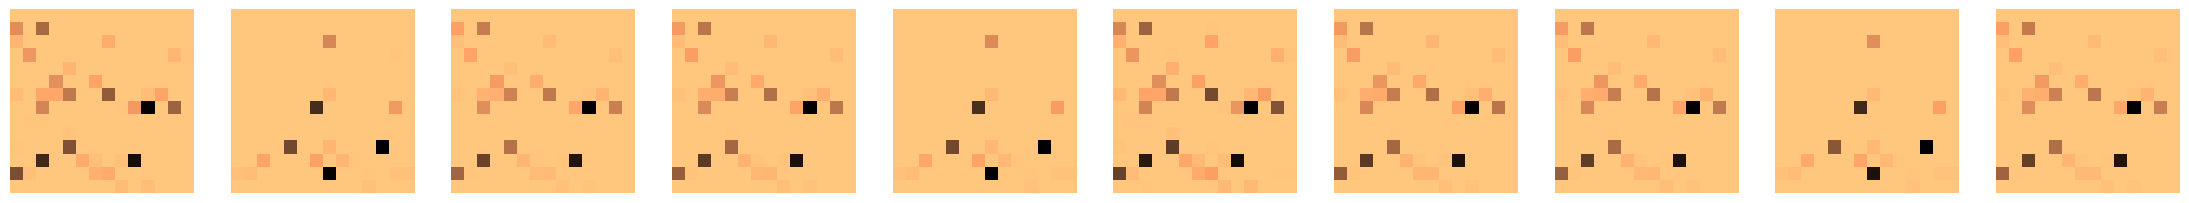

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - c_gp: 0.0060 - c_loss: 0.0598 - c_wass_loss: 2.4696e-04 - g_loss: -0.0159
Epoch 352/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 353/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0057 - c_loss: 0.0571 - c_wass_loss: 4.8335e-05 - g_loss: -0.0145
Epoch 354/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0060 - c_loss: 0.0600 - c_wass_loss: 4.5997e-04 - g_loss: -0.0136
Epoch 355/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0058 - c_loss: 0.0584 - c_wass_loss: 7.4487e-04 - g_loss: -0.0118
Epoch 356/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0060 - c_loss: 0.0606 - c_wass_loss: 1.0578e-04 - g_loss: -0.0107
Epoch 357/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0060 - c_loss: 0.0601 - c_wass_loss: 4.2543e-04 - g_loss: -0.0087
Epoch 358/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0060 - c_loss: 0.0608 - c_wass_loss: 3.4002e-0

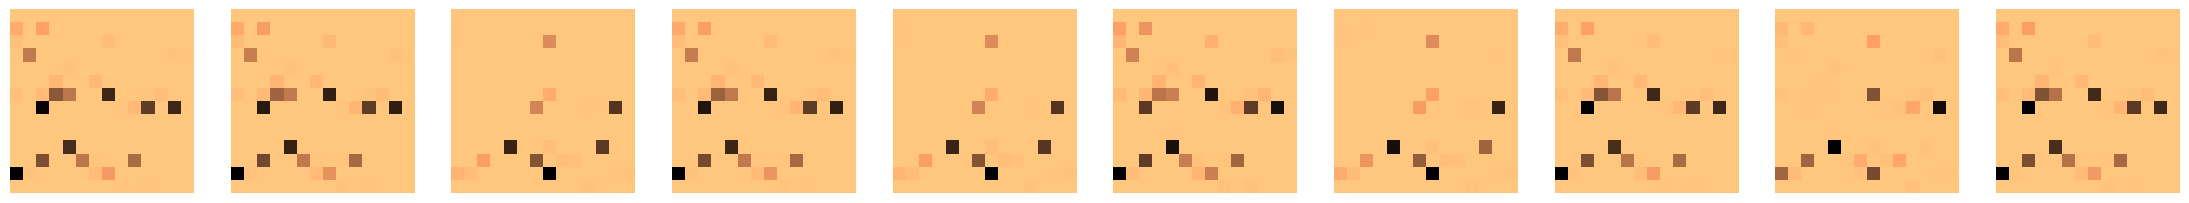

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - c_gp: 0.0061 - c_loss: 0.0615 - c_wass_loss: 1.7705e-04 - g_loss: -0.0046
Epoch 362/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0595 - c_wass_loss: 3.2657e-04 - g_loss: -0.0029
Epoch 363/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 364/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0060 - c_loss: 0.0600 - c_wass_loss: 1.5557e-04 - g_loss: -0.0016
Epoch 365/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0061 - c_loss: 0.0614 - c_wass_loss: 1.3513e-04 - g_loss: -7.7691e-04
Epoch 366/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0063 - c_loss: 0.0631 - c_wass_loss: 8.2667e-05 - g_loss: -9.2556e-04
Epoch 367/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0064 - c_loss: 0.0638 - c_wass_loss: 2.0853e-04 - g_loss: -1.5055e-04
Epoch 368/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0063 - c_loss: 0.0632 - c_wass_lo

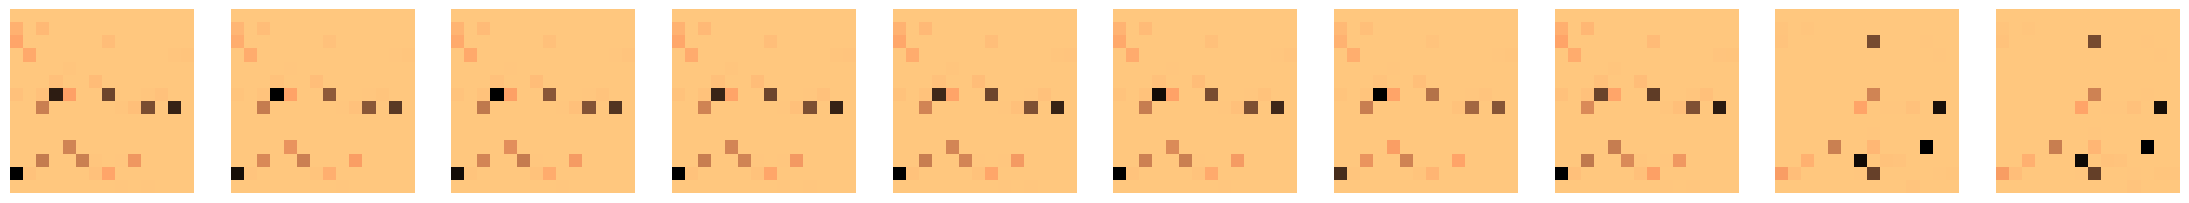

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - c_gp: 0.0062 - c_loss: 0.0616 - c_wass_loss: 2.0938e-05 - g_loss: 7.7024e-04
Epoch 372/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0562 - c_wass_loss: 2.3341e-04 - g_loss: 0.0011  
Epoch 373/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0059 - c_loss: 0.0597 - c_wass_loss: 5.5135e-04 - g_loss: 9.7572e-04
Epoch 374/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 375/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0059 - c_loss: 0.0595 - c_wass_loss: 1.2028e-04 - g_loss: 0.0015
Epoch 376/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0059 - c_loss: 0.0588 - c_wass_loss: -8.4167e-05 - g_loss: 0.0014
Epoch 377/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0061 - c_loss: 0.0607 - c_wass_loss: 3.9199e-05 - g_loss: 0.0013
Epoch 378/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0057 - c_loss: 0.0568 - c_wass_loss: 1.05

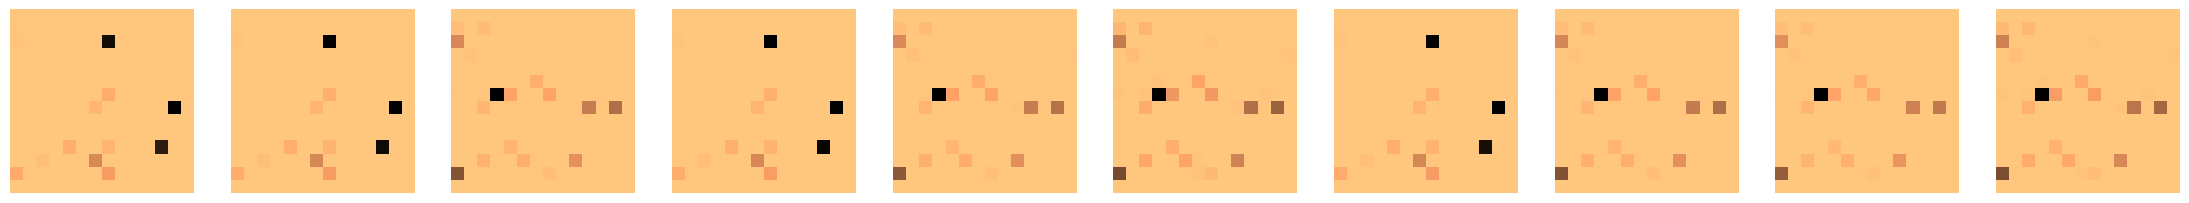

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.0056 - c_loss: 0.0561 - c_wass_loss: 3.1233e-04 - g_loss: 0.0011
Epoch 382/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0559 - c_wass_loss: -1.9368e-04 - g_loss: 9.7899e-04
Epoch 383/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0058 - c_loss: 0.0575 - c_wass_loss: -1.7549e-04 - g_loss: 9.2177e-04
Epoch 384/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0555 - c_wass_loss: 1.3299e-04 - g_loss: 9.9393e-04
Epoch 385/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 386/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0053 - c_loss: 0.0526 - c_wass_loss: -1.3094e-04 - g_loss: 4.5718e-04
Epoch 387/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - c_gp: 0.0057 - c_loss: 0.0572 - c_wass_loss: 1.1047e-04 - g_loss: 9.5989e-04
Epoch 388/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0566 - c_was

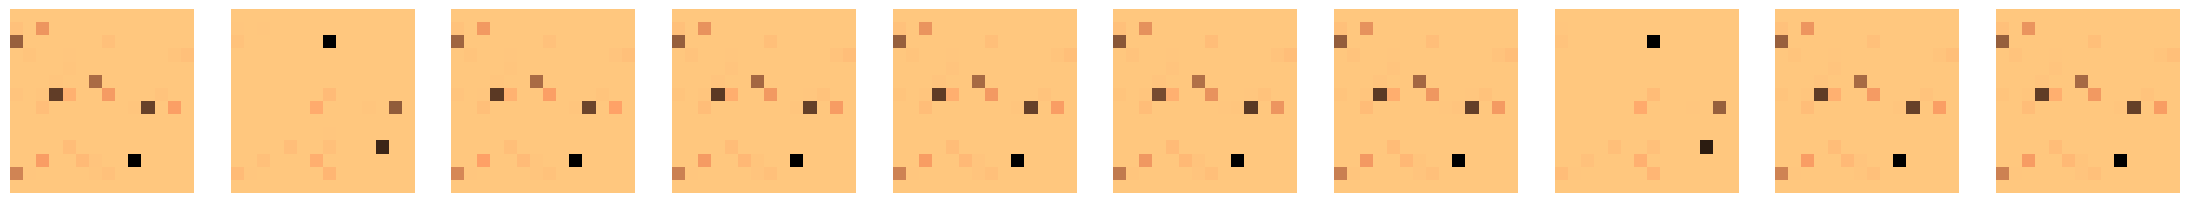

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - c_gp: 0.0051 - c_loss: 0.0508 - c_wass_loss: -2.7868e-05 - g_loss: 5.2446e-04
Epoch 392/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0053 - c_loss: 0.0530 - c_wass_loss: 1.0709e-04 - g_loss: 7.4032e-04
Epoch 393/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0557 - c_wass_loss: 2.8385e-04 - g_loss: 4.1527e-04
Epoch 394/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0057 - c_loss: 0.0568 - c_wass_loss: -2.7418e-05 - g_loss: 6.3336e-04
Epoch 395/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0052 - c_loss: 0.0518 - c_wass_loss: -1.3778e-04 - g_loss: 0.0011
Epoch 396/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 397/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0055 - c_loss: 0.0547 - c_wass_loss: -5.3119e-05 - g_loss: 9.6479e-05
Epoch 398/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0053 - c_loss: 0.0530 - c_wa

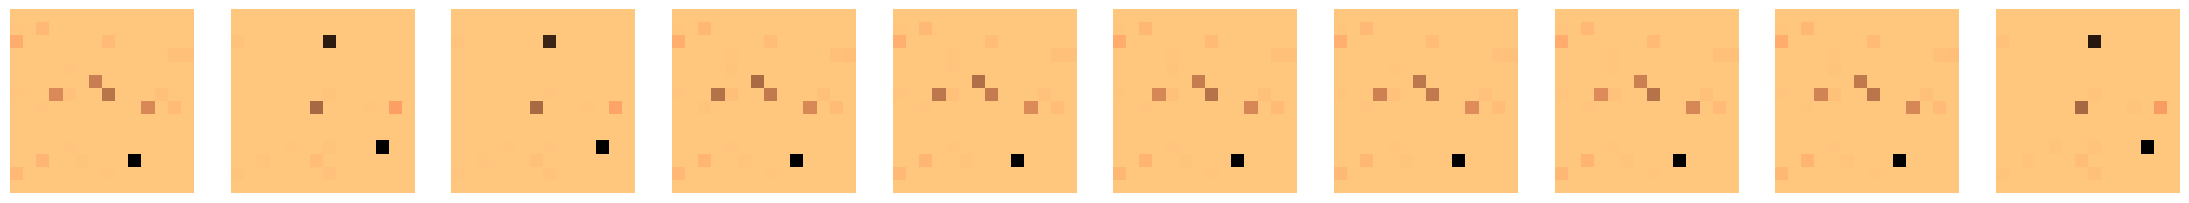

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0055 - c_loss: 0.0555 - c_wass_loss: 2.4520e-05 - g_loss: 2.4739e-04
Epoch 402/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0052 - c_loss: 0.0522 - c_wass_loss: 1.5674e-04 - g_loss: 5.1548e-04
Epoch 403/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0053 - c_loss: 0.0536 - c_wass_loss: 1.5668e-04 - g_loss: 2.5008e-04
Epoch 404/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0544 - c_wass_loss: -2.3184e-04 - g_loss: -7.8051e-05
Epoch 405/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0054 - c_loss: 0.0540 - c_wass_loss: -2.4519e-04 - g_loss: 5.6609e-05
Epoch 406/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0051 - c_loss: 0.0510 - c_wass_loss: -2.9923e-04 - g_loss: 4.3653e-05
Epoch 407/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 408/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0533 - 

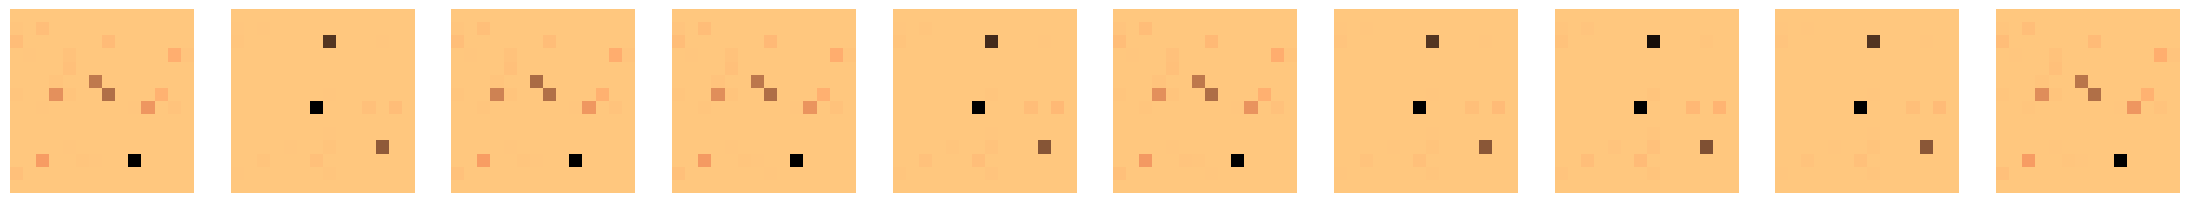

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0052 - c_loss: 0.0521 - c_wass_loss: -2.8807e-04 - g_loss: -6.2566e-04
Epoch 412/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0530 - c_wass_loss: -1.7027e-04 - g_loss: -5.6000e-04
Epoch 413/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0532 - c_wass_loss: 8.7999e-05 - g_loss: -9.2571e-04
Epoch 414/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0485 - c_wass_loss: 1.7579e-05 - g_loss: -0.0011
Epoch 415/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0052 - c_loss: 0.0526 - c_wass_loss: 1.6402e-04 - g_loss: -6.2021e-04
Epoch 416/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0053 - c_loss: 0.0535 - c_wass_loss: 2.3230e-04 - g_loss: -5.5572e-04
Epoch 417/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0050 - c_loss: 0.0495 - c_wass_loss: -3.3703e-04 - g_loss: -7.2897e-04
Epoch 418/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 

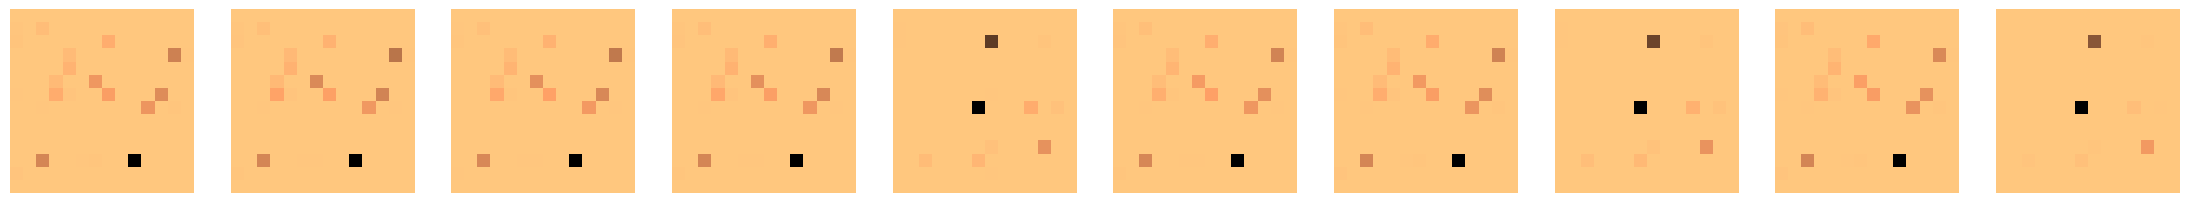

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - c_gp: 0.0052 - c_loss: 0.0523 - c_wass_loss: 8.3763e-05 - g_loss: -8.7974e-04
Epoch 422/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0051 - c_loss: 0.0510 - c_wass_loss: -2.4511e-04 - g_loss: -9.1147e-04
Epoch 423/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0054 - c_loss: 0.0544 - c_wass_loss: 3.1655e-05 - g_loss: -0.0012
Epoch 424/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - c_gp: 0.0052 - c_loss: 0.0518 - c_wass_loss: 1.5489e-04 - g_loss: -0.0013
Epoch 425/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0051 - c_loss: 0.0514 - c_wass_loss: 8.4594e-05 - g_loss: -0.0011
Epoch 426/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0053 - c_loss: 0.0526 - c_wass_loss: -2.9318e-04 - g_loss: -0.0011
Epoch 427/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0055 - c_loss: 0.0546 - c_wass_loss: 3.7846e-05 - g_loss: -7.0048e-04
Epoch 428/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0050 - c_loss: 0.0505 - c_wass_loss: 5.611

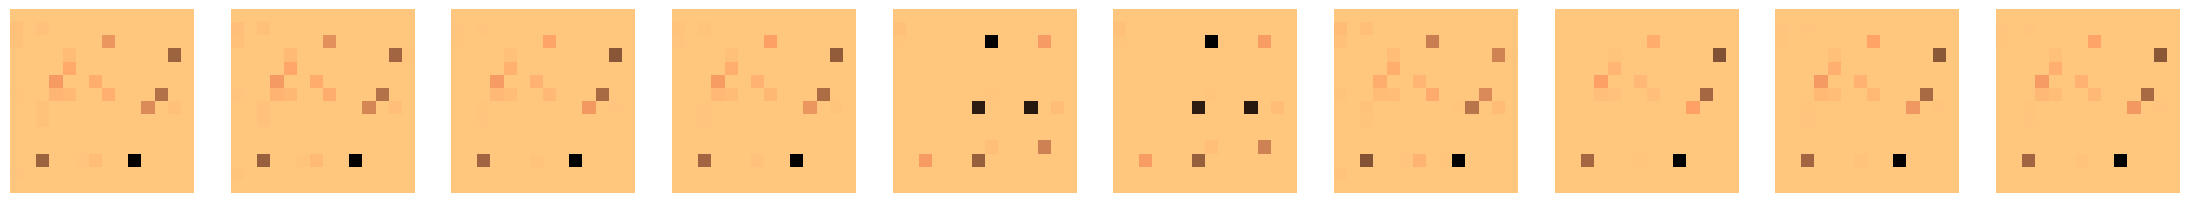

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.0052 - c_loss: 0.0518 - c_wass_loss: -8.5475e-05 - g_loss: -7.8254e-04
Epoch 432/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0057 - c_loss: 0.0567 - c_wass_loss: -3.1059e-04 - g_loss: -1.9676e-05
Epoch 433/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0541 - c_wass_loss: -8.5244e-05 - g_loss: 1.2753e-04
Epoch 434/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0049 - c_loss: 0.0486 - c_wass_loss: -2.6641e-04 - g_loss: 1.2313e-04
Epoch 435/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0050 - c_loss: 0.0502 - c_wass_loss: -2.1374e-04 - g_loss: -4.4007e-04
Epoch 436/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0052 - c_loss: 0.0521 - c_wass_loss: -2.9992e-05 - g_loss: 2.9408e-04
Epoch 437/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0545 - c_wass_loss: 1.8574e-04 - g_loss: -9.2786e-05
Epoch 438/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0051 - c_loss: 0.0512 - c

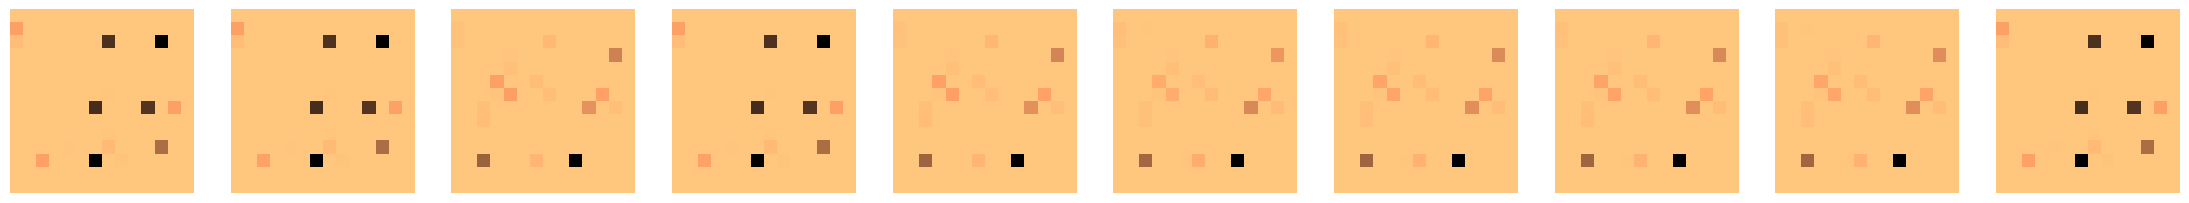

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - c_gp: 0.0052 - c_loss: 0.0519 - c_wass_loss: 3.4992e-05 - g_loss: -3.3002e-04
Epoch 442/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0051 - c_loss: 0.0514 - c_wass_loss: 2.4180e-05 - g_loss: -3.0951e-05
Epoch 443/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0051 - c_loss: 0.0515 - c_wass_loss: 2.5215e-05 - g_loss: 1.0242e-04
Epoch 444/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0051 - c_loss: 0.0511 - c_wass_loss: -3.6082e-04 - g_loss: 5.4550e-05
Epoch 445/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0052 - c_loss: 0.0519 - c_wass_loss: 3.3660e-05 - g_loss: -9.8221e-06
Epoch 446/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0056 - c_loss: 0.0555 - c_wass_loss: -3.5177e-04 - g_loss: -8.1223e-04
Epoch 447/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0051 - c_loss: 0.0509 - c_wass_loss: 1.4828e-04 - g_loss: -7.3631e-04
Epoch 448/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0052 - c_loss: 0.0521 - c_wa

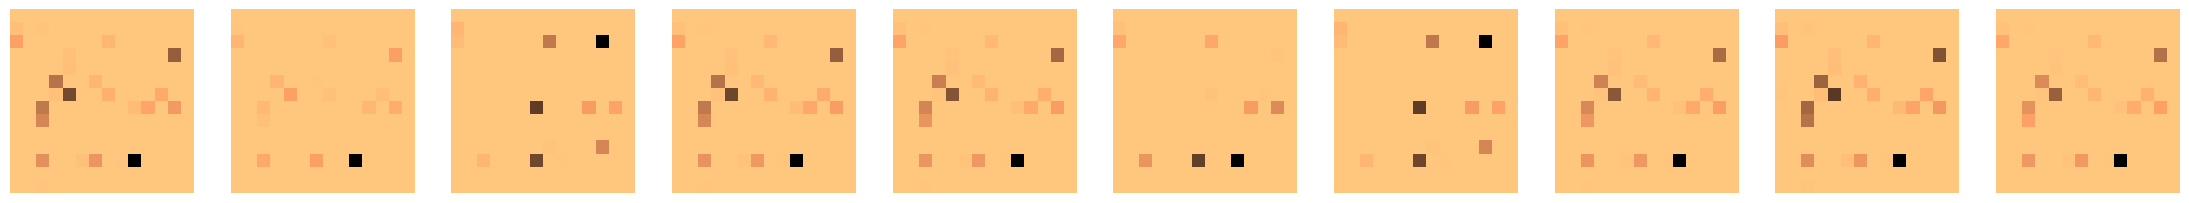

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 452/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0525 - c_wass_loss: -2.0170e-04 - g_loss: -0.0011
Epoch 453/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0051 - c_loss: 0.0512 - c_wass_loss: 6.9696e-04 - g_loss: -0.0015
Epoch 454/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0051 - c_loss: 0.0505 - c_wass_loss: -1.5904e-04 - g_loss: -0.0012
Epoch 455/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0056 - c_loss: 0.0560 - c_wass_loss: -6.1119e-05 - g_loss: -0.0011  
Epoch 456/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0051 - c_loss: 0.0511 - c_wass_loss: -1.9146e-04 - g_loss: -0.0018
Epoch 457/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0051 - c_loss: 0.0511 - c_wass_loss: -3.4312e-04 - g_loss: -0.0018
Epoch 458/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0050 - c_loss: 0.0500 - c_wass_loss: -

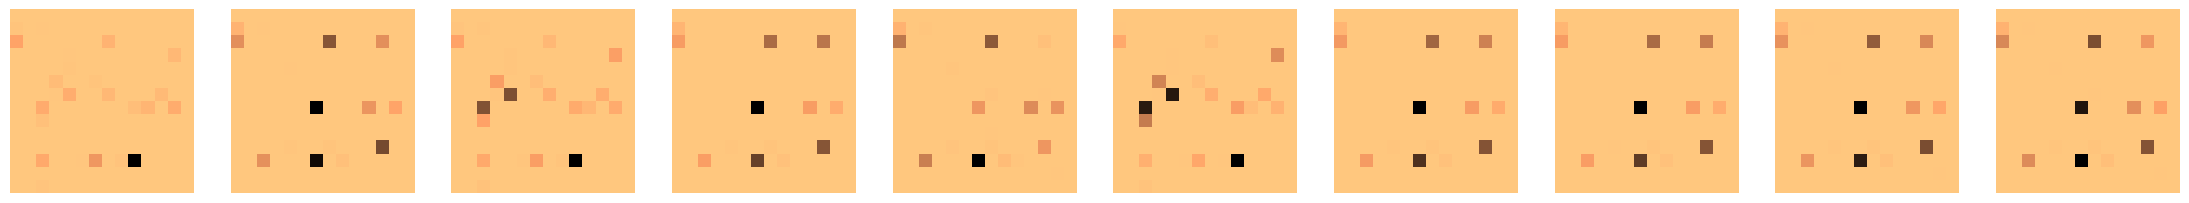

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - c_gp: 0.0050 - c_loss: 0.0500 - c_wass_loss: 1.0766e-04 - g_loss: -0.0027
Epoch 462/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 463/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0054 - c_loss: 0.0543 - c_wass_loss: 6.8106e-05 - g_loss: -0.0025
Epoch 464/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0470 - c_wass_loss: 8.6290e-05 - g_loss: -0.0022
Epoch 465/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0053 - c_loss: 0.0533 - c_wass_loss: -1.5316e-04 - g_loss: -0.0027
Epoch 466/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0049 - c_loss: 0.0489 - c_wass_loss: 1.0278e-05 - g_loss: -0.0024
Epoch 467/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - c_gp: 0.0051 - c_loss: 0.0515 - c_wass_loss: 2.5057e-04 - g_loss: -0.0021
Epoch 468/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0052 - c_loss: 0.0518 - c_wass_loss: -2.1330e

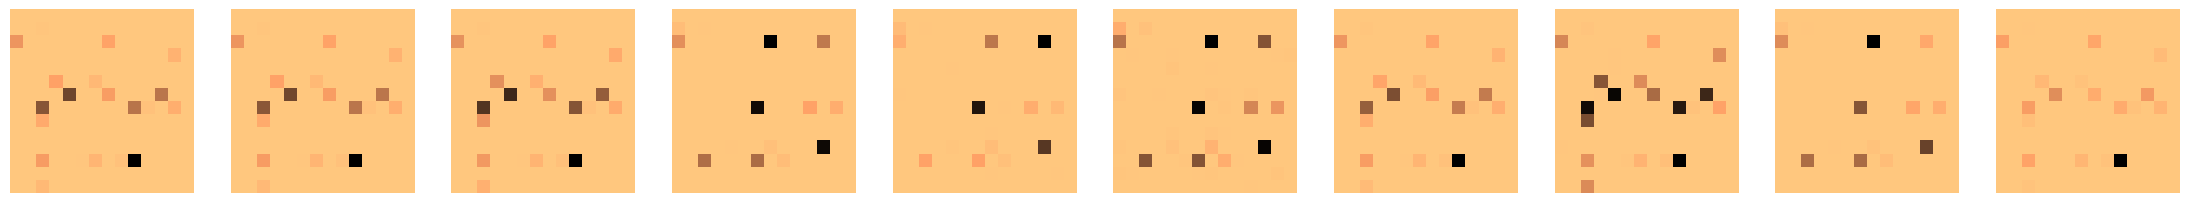

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0055 - c_loss: 0.0545 - c_wass_loss: -1.6726e-04 - g_loss: -0.0023
Epoch 472/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0536 - c_wass_loss: -1.7035e-04 - g_loss: -0.0022
Epoch 473/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 474/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0050 - c_loss: 0.0505 - c_wass_loss: -9.1653e-06 - g_loss: -0.0020
Epoch 475/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0492 - c_wass_loss: -1.3562e-04 - g_loss: -0.0017
Epoch 476/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0495 - c_wass_loss: 8.4508e-05 - g_loss: -0.0019
Epoch 477/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0052 - c_loss: 0.0517 - c_wass_loss: -1.2890e-05 - g_loss: -0.0017
Epoch 478/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0502 - c_wass_loss: 8.88

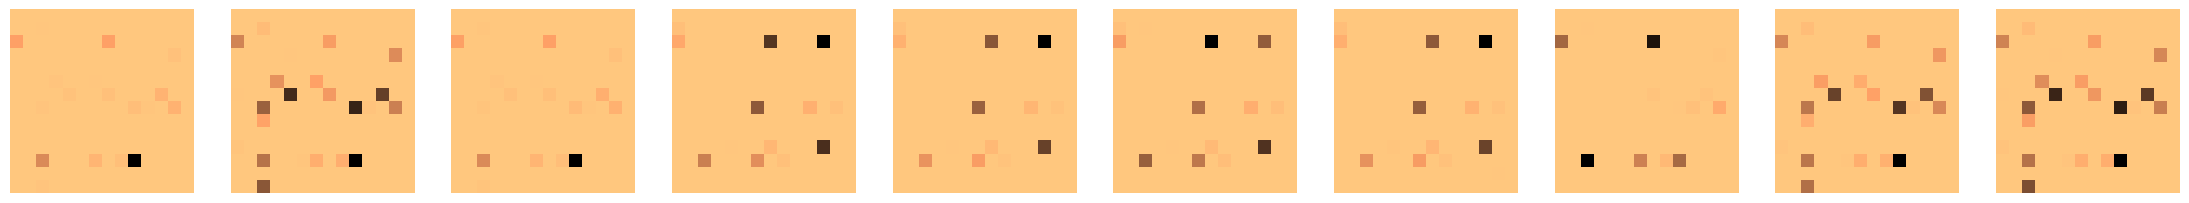

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0051 - c_loss: 0.0511 - c_wass_loss: 1.6751e-04 - g_loss: -0.0019
Epoch 482/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0500 - c_wass_loss: 4.6013e-05 - g_loss: -0.0020
Epoch 483/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0050 - c_loss: 0.0507 - c_wass_loss: 2.2344e-04 - g_loss: -0.0019
Epoch 484/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 485/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0049 - c_loss: 0.0489 - c_wass_loss: 1.8844e-04 - g_loss: -0.0019
Epoch 486/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0052 - c_loss: 0.0516 - c_wass_loss: 6.4510e-05 - g_loss: -0.0020
Epoch 487/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0049 - c_loss: 0.0483 - c_wass_loss: -3.0610e-04 - g_loss: -0.0020
Epoch 488/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0054 - c_loss: 0.0548 - c_wass_loss: 3.2178e-

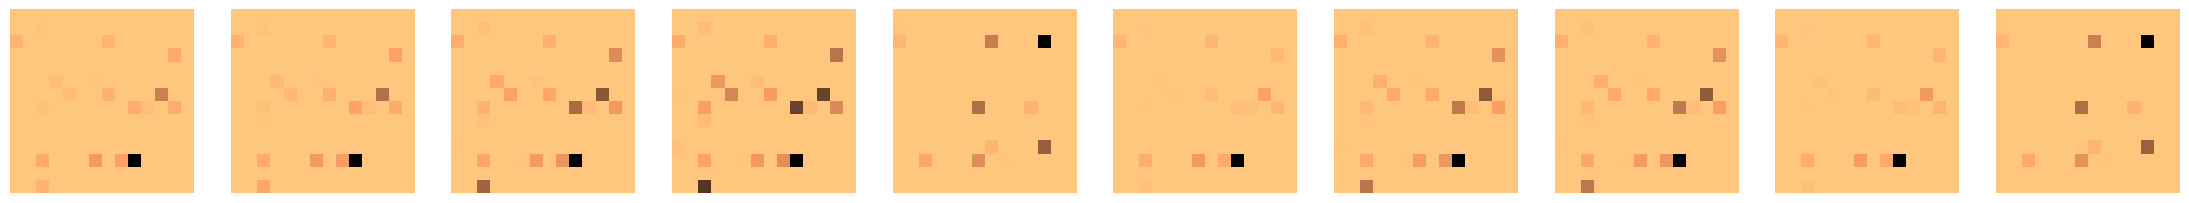

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - c_gp: 0.0052 - c_loss: 0.0524 - c_wass_loss: 1.3199e-05 - g_loss: -0.0026
Epoch 492/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0473 - c_wass_loss: -5.8911e-05 - g_loss: -0.0024
Epoch 493/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0051 - c_loss: 0.0513 - c_wass_loss: -1.3124e-04 - g_loss: -0.0029
Epoch 494/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0503 - c_wass_loss: 1.4293e-04 - g_loss: -0.0025
Epoch 495/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 496/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0047 - c_loss: 0.0471 - c_wass_loss: 6.2705e-05 - g_loss: -0.0019
Epoch 497/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0048 - c_loss: 0.0482 - c_wass_loss: -1.6918e-04 - g_loss: -0.0026
Epoch 498/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0487 - c_wass_loss: 7.4103

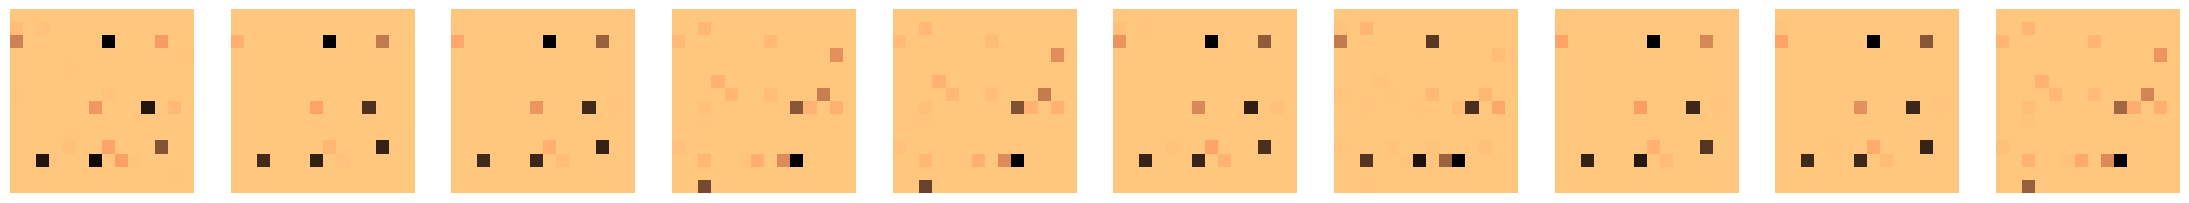

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.0049 - c_loss: 0.0488 - c_wass_loss: -4.8568e-05 - g_loss: -0.0028
Epoch 502/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0052 - c_loss: 0.0516 - c_wass_loss: -4.1919e-04 - g_loss: -0.0024
Epoch 503/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0047 - c_loss: 0.0464 - c_wass_loss: -3.1033e-04 - g_loss: -0.0025
Epoch 504/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0047 - c_loss: 0.0473 - c_wass_loss: 9.8868e-05 - g_loss: -0.0028
Epoch 505/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0051 - c_loss: 0.0516 - c_wass_loss: 2.5800e-04 - g_loss: -0.0025
Epoch 506/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 507/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0470 - c_wass_loss: 2.2117e-04 - g_loss: -0.0025
Epoch 508/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0048 - c_loss: 0.0476 - c_wass_loss: -4.796

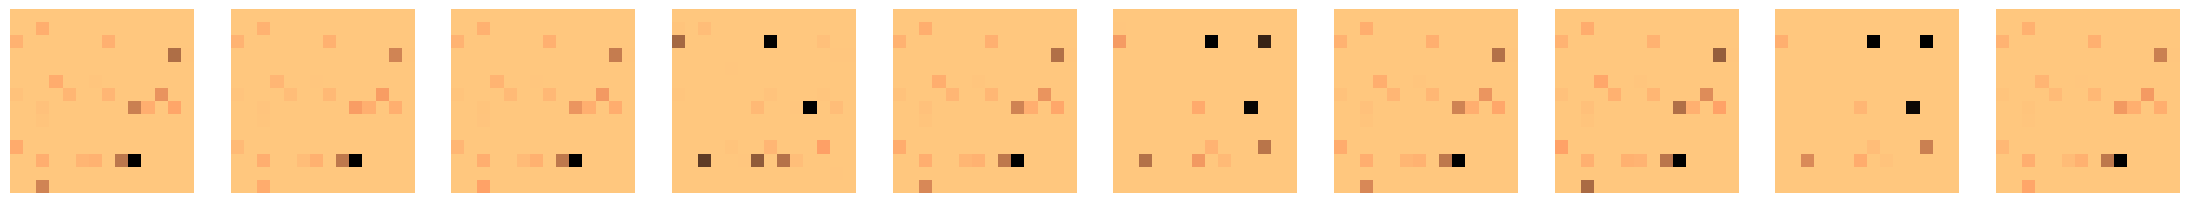

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - c_gp: 0.0047 - c_loss: 0.0472 - c_wass_loss: -2.7318e-04 - g_loss: -0.0025
Epoch 512/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0465 - c_wass_loss: -2.5386e-05 - g_loss: -0.0026
Epoch 513/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0495 - c_wass_loss: -1.3096e-06 - g_loss: -0.0027
Epoch 514/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0502 - c_wass_loss: 1.3308e-04 - g_loss: -0.0025
Epoch 515/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0050 - c_loss: 0.0502 - c_wass_loss: -1.6048e-04 - g_loss: -0.0027
Epoch 516/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0495 - c_wass_loss: 3.0802e-04 - g_loss: -0.0025
Epoch 517/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 518/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0047 - c_loss: 0.0465 - c_wass_loss: -1.47

2024-09-18 18:19:27.915439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16040414506481350282


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0473 - c_wass_loss: 1.1803e-04 - g_loss: -0.0029
Epoch 520/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0048 - c_loss: 0.0476 - c_wass_loss: -2.1225e-04 - g_loss: -0.0028
Epoch 521/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0049 - c_loss: 0.0484 - c_wass_loss: -3.6934e-04 - g_loss: -0.0030

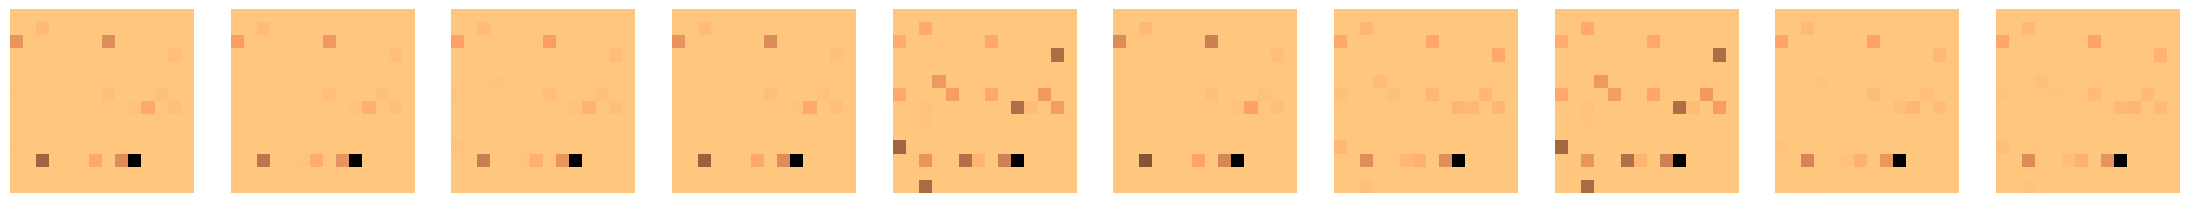

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0049 - c_loss: 0.0483 - c_wass_loss: -3.0800e-04 - g_loss: -0.0030
Epoch 522/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0049 - c_loss: 0.0492 - c_wass_loss: -2.4444e-04 - g_loss: -0.0031
Epoch 523/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0045 - c_loss: 0.0446 - c_wass_loss: -1.8861e-04 - g_loss: -0.0032
Epoch 524/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0048 - c_loss: 0.0476 - c_wass_loss: -1.2267e-04 - g_loss: -0.0033
Epoch 525/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0467 - c_wass_loss: 1.3023e-04 - g_loss: -0.0033
Epoch 526/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0049 - c_loss: 0.0487 - c_wass_loss: -2.6690e-04 - g_loss: -0.0038
Epoch 527/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0049 - c_loss: 0.0493 - c_wass_loss: 2.1631e-04 - g_loss: -0.0031
Epoch 528/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e

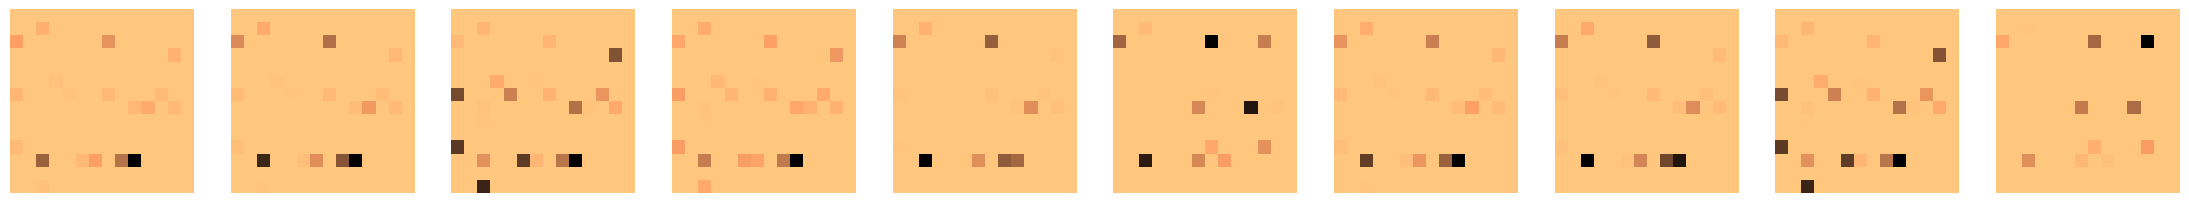

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - c_gp: 0.0049 - c_loss: 0.0494 - c_wass_loss: 9.8248e-06 - g_loss: -0.0034
Epoch 532/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0046 - c_loss: 0.0455 - c_wass_loss: -1.9831e-04 - g_loss: -0.0036
Epoch 533/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0047 - c_loss: 0.0472 - c_wass_loss: 3.4430e-04 - g_loss: -0.0035
Epoch 534/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0493 - c_wass_loss: 3.1224e-04 - g_loss: -0.0036
Epoch 535/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0045 - c_loss: 0.0446 - c_wass_loss: 1.3568e-07 - g_loss: -0.0035
Epoch 536/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0051 - c_loss: 0.0514 - c_wass_loss: -1.6457e-05 - g_loss: -0.0030
Epoch 537/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0047 - c_loss: 0.0469 - c_wass_loss: -1.7096e-04 - g_loss: -0.0030
Epoch 538/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0045 - c_loss: 0.0446 - c_wass_loss: -9.0200e-05 - g_

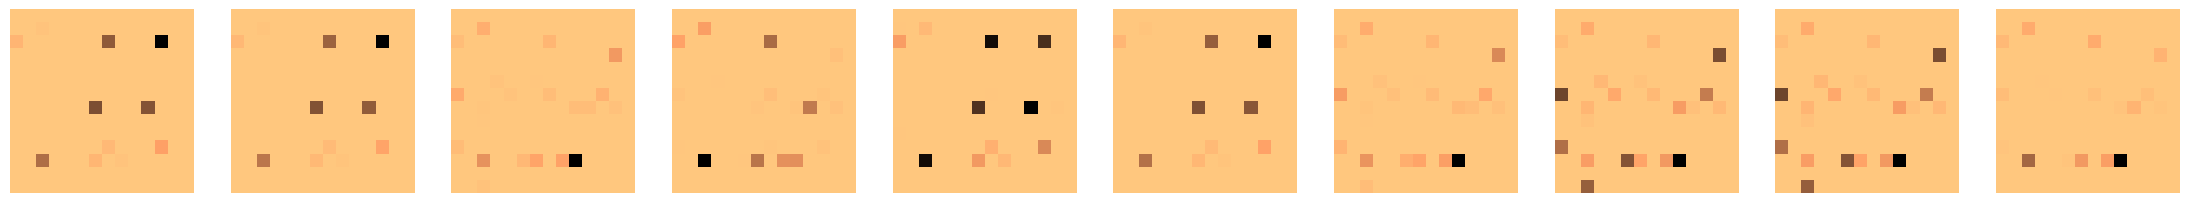

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - c_gp: 0.0050 - c_loss: 0.0502 - c_wass_loss: 1.2328e-04 - g_loss: -0.0036
Epoch 542/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0046 - c_loss: 0.0453 - c_wass_loss: -2.0599e-04 - g_loss: -0.0037
Epoch 543/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0491 - c_wass_loss: 7.2785e-05 - g_loss: -0.0034
Epoch 544/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0042 - c_loss: 0.0418 - c_wass_loss: -3.4755e-04 - g_loss: -0.0032
Epoch 545/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0044 - c_loss: 0.0439 - c_wass_loss: 3.3242e-04 - g_loss: -0.0032
Epoch 546/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0048 - c_loss: 0.0484 - c_wass_loss: 7.3178e-05 - g_loss: -0.0030
Epoch 547/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0048 - c_loss: 0.0479 - c_wass_loss: 2.9996e-04 - g_loss: -0.0034
Epoch 548/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0045 - c_loss: 0.0451 - c_wass_loss: -5.0074e-06 - g_l

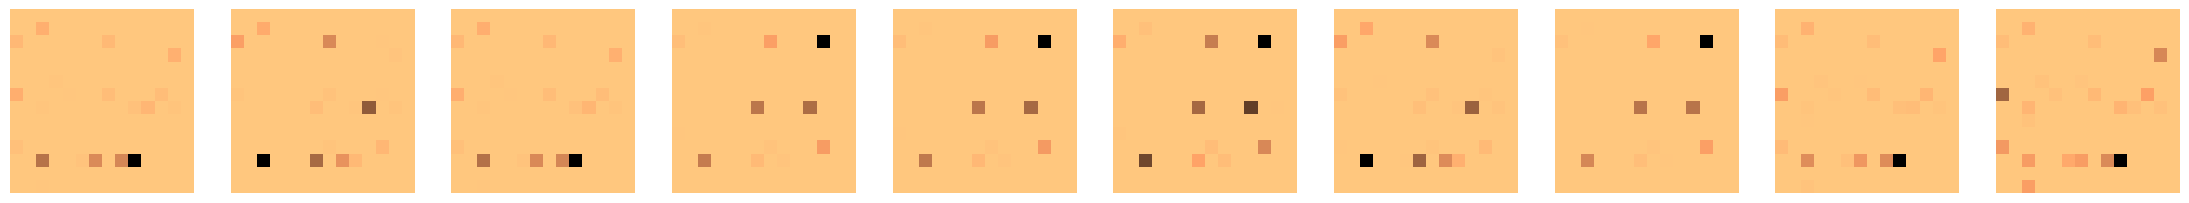

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - c_gp: 0.0045 - c_loss: 0.0455 - c_wass_loss: 1.9956e-04 - g_loss: -0.0037
Epoch 552/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0046 - c_loss: 0.0464 - c_wass_loss: 8.1271e-05 - g_loss: -0.0039
Epoch 553/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0048 - c_loss: 0.0483 - c_wass_loss: -1.7082e-04 - g_loss: -0.0037
Epoch 554/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0046 - c_loss: 0.0455 - c_wass_loss: -2.2220e-04 - g_loss: -0.0039
Epoch 555/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0471 - c_wass_loss: 1.1735e-04 - g_loss: -0.0038
Epoch 556/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0048 - c_loss: 0.0478 - c_wass_loss: 2.3540e-05 - g_loss: -0.0040
Epoch 557/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0046 - c_loss: 0.0463 - c_wass_loss: 3.3518e-04 - g_loss: -0.0040
Epoch 558/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0489 - c_wass_loss: -1.0808e-04 - g_l

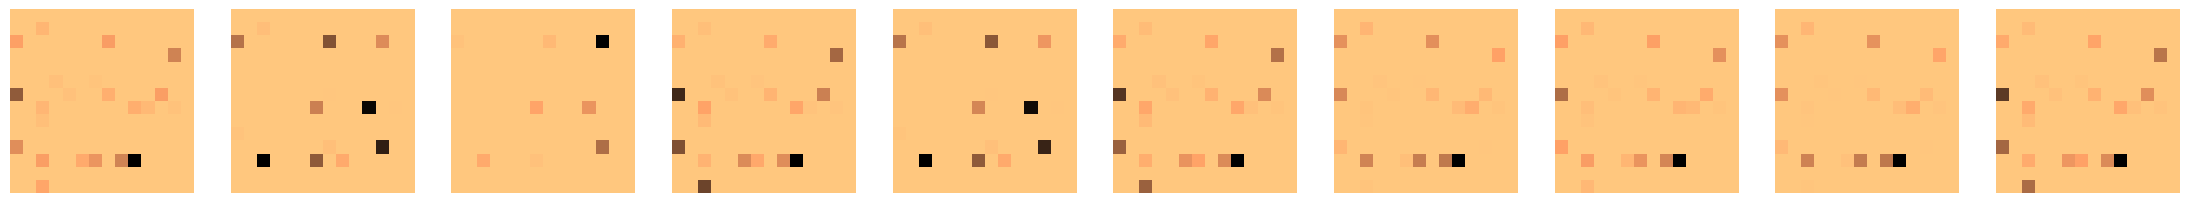

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 562/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0046 - c_loss: 0.0461 - c_wass_loss: -9.8513e-05 - g_loss: -0.0043
Epoch 563/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0046 - c_loss: 0.0460 - c_wass_loss: -1.5143e-05 - g_loss: -0.0042
Epoch 564/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0048 - c_loss: 0.0482 - c_wass_loss: -5.3878e-05 - g_loss: -0.0041
Epoch 565/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0497 - c_wass_loss: 2.6343e-04 - g_loss: -0.0043
Epoch 566/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0047 - c_loss: 0.0467 - c_wass_loss: -2.0550e-04 - g_loss: -0.0039
Epoch 567/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0493 - c_wass_loss: -6.7830e-05 - g_loss: -0.0042
Epoch 568/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0045 - c_loss: 0.0447 - c_wass_loss: -7.

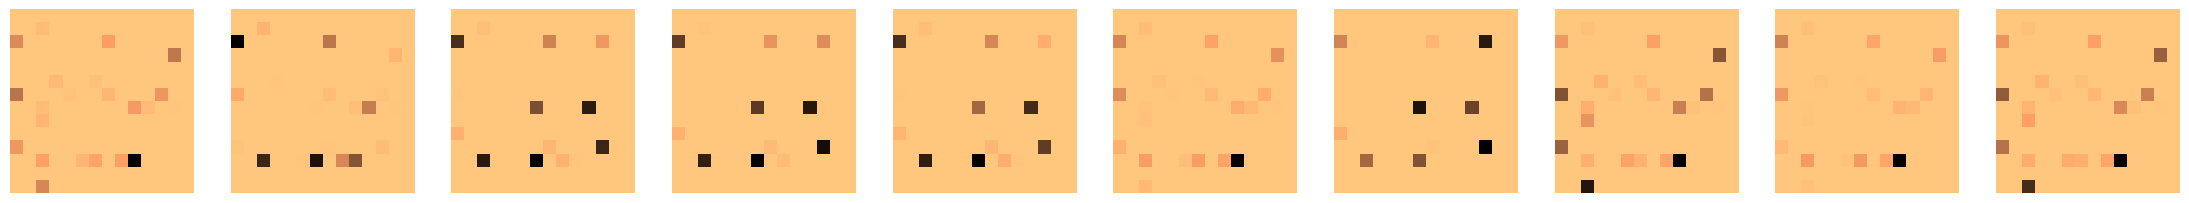

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - c_gp: 0.0045 - c_loss: 0.0451 - c_wass_loss: -7.3030e-06 - g_loss: -0.0038
Epoch 572/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 573/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0043 - c_loss: 0.0429 - c_wass_loss: 4.9353e-05 - g_loss: -0.0041
Epoch 574/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0046 - c_loss: 0.0462 - c_wass_loss: 1.3892e-04 - g_loss: -0.0038
Epoch 575/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0490 - c_wass_loss: 2.6719e-04 - g_loss: -0.0039
Epoch 576/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0045 - c_loss: 0.0455 - c_wass_loss: 3.9411e-05 - g_loss: -0.0038
Epoch 577/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0507 - c_wass_loss: 3.2570e-04 - g_loss: -0.0038
Epoch 578/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - c_gp: 0.0046 - c_loss: 0.0462 - c_wass_loss: 6.5465e-

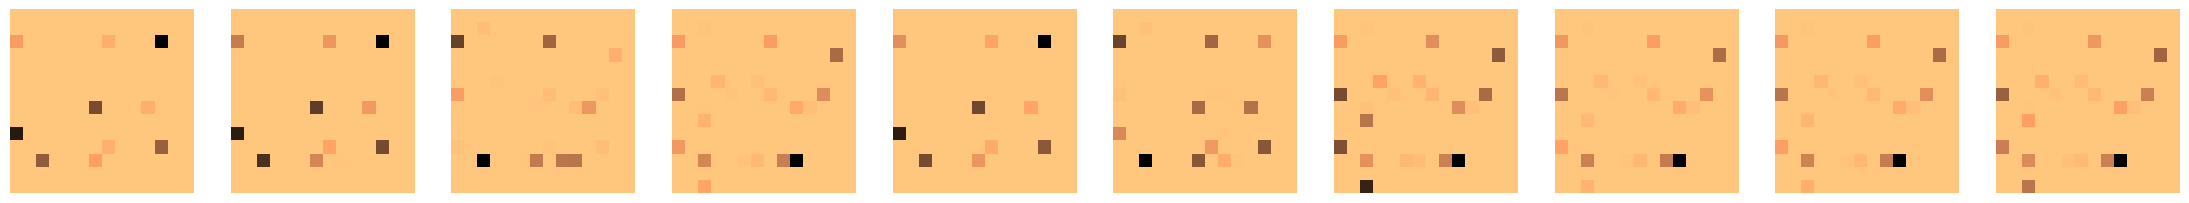

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0050 - c_loss: 0.0498 - c_wass_loss: 2.1291e-04 - g_loss: -0.0042
Epoch 582/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0047 - c_loss: 0.0462 - c_wass_loss: -3.7295e-04 - g_loss: -0.0046
Epoch 583/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 584/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0050 - c_loss: 0.0502 - c_wass_loss: 8.5702e-05 - g_loss: -0.0045
Epoch 585/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0049 - c_loss: 0.0493 - c_wass_loss: 2.9978e-04 - g_loss: -0.0040
Epoch 586/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0465 - c_wass_loss: -7.1607e-05 - g_loss: -0.0040
Epoch 587/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0471 - c_wass_loss: -2.8657e-04 - g_loss: -0.0044
Epoch 588/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0049 - c_loss: 0.0491 - c_wass_loss: -1.006

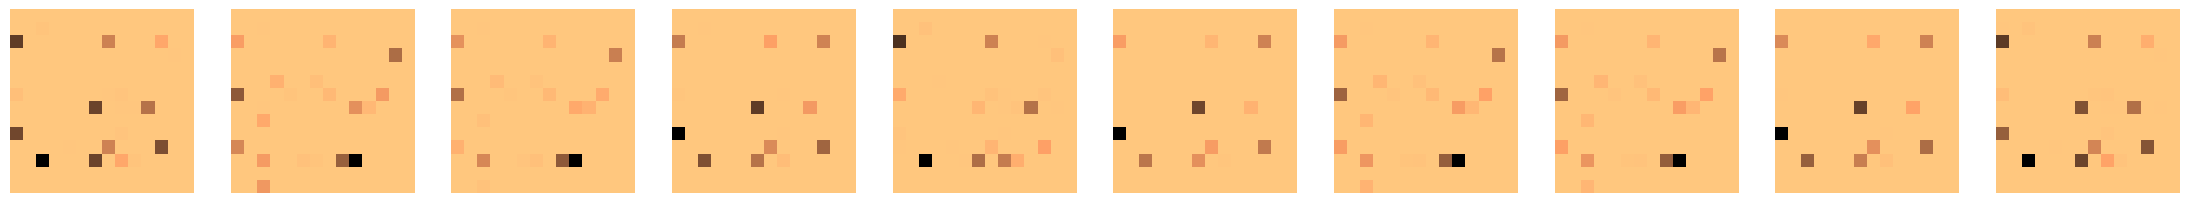

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.0048 - c_loss: 0.0485 - c_wass_loss: 1.1056e-04 - g_loss: -0.0046
Epoch 592/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0047 - c_loss: 0.0467 - c_wass_loss: 2.0632e-04 - g_loss: -0.0049
Epoch 593/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0048 - c_loss: 0.0484 - c_wass_loss: 7.9255e-05 - g_loss: -0.0045
Epoch 594/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 595/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0049 - c_loss: 0.0495 - c_wass_loss: 2.9728e-04 - g_loss: -0.0047
Epoch 596/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0046 - c_loss: 0.0465 - c_wass_loss: 2.8979e-05 - g_loss: -0.0044
Epoch 597/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0464 - c_wass_loss: -2.3206e-04 - g_loss: -0.0045
Epoch 598/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0047 - c_loss: 0.0468 - c_wass_loss: -1.0226e

In [254]:
if TRAIN:
    dataset = tf.data.Dataset.from_tensors(X.astype("float32")).repeat(REPEAT_DATA)

    wgangp.fit(
        dataset,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


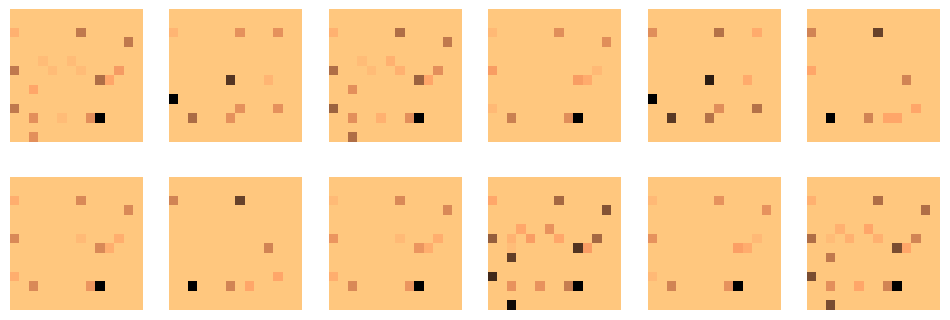

In [255]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = wgangp.generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

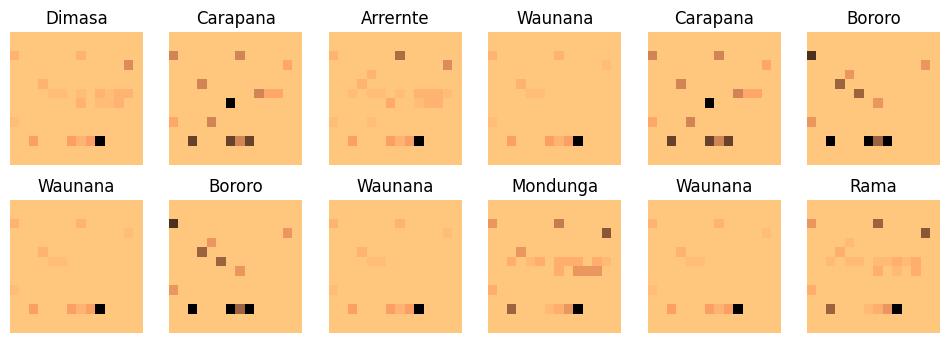

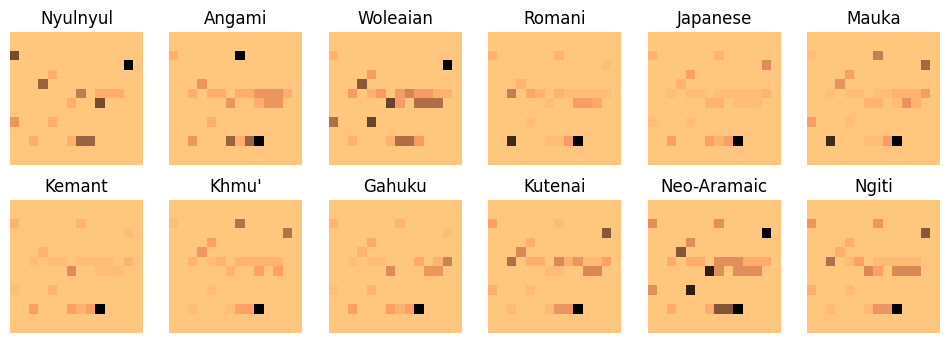

(0.12755102040816327, 0.23581632653061224, 0.8520408163265306)

In [256]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

# random samples
gen = np.random.default_rng()
sample_indices = gen.choice(origin.shape[0], 12, replace=False)
samples = origin[sample_indices]
sample_names = languages[:, 1][sample_indices]

display_rows(samples, titles=sample_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.min(closest_diff), np.mean(closest_diff), np.max(closest_diff)

In [259]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((852, 14, 14, 1), (0,))

In [261]:
parameters.shape, parameters[0]

((188, 2), array(['1A', 'Consonant Inventories'], dtype=object))

In [258]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

param_df.head(5)

ID  \
Area      Chapter                                   
Phonology Consonant Inventories                1A   
          Vowel Quality Inventories            2A   
          Consonant-Vowel Ratio                3A   
          Voicing in Plosives and Fricatives   4A   
          Voicing and Gaps in Plosive Systems  5A   

                                                                              Name  
Area      Chapter                                                                   
Phonology Consonant Inventories                              Consonant Inventories  
          Vowel Quality Inventories                      Vowel Quality Inventories  
          Consonant-Vowel Ratio                              Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives    Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems  Voicing and Gaps in Plosive Systems